In [2]:
import tkinter as tk
from tkinter import filedialog, messagebox, scrolledtext
from tkinter import ttk
import pandas as pd
import csv
import random
import threading
import time
import copy
import numpy as np
import concurrent.futures

class AllocationApp:
    def __init__(self, root):
        self.root = root
        self.root.title("Student Allocation App")
        self.root.geometry("800x600")
        self.root.state('zoomed')  # Start maximized

        # Set theme and style
        self.style = ttk.Style()
        self.style.theme_use('clam')  # Use the 'clam' theme for a modern look
        self.style.configure('TFrame', background='#e0f7fa')
        self.style.configure('TLabel', background='#e0f7fa', font=('Helvetica', 10))
        self.style.configure('TButton', font=('Helvetica', 10), padding=6, background='#00796b', foreground='#ffffff')
        self.style.configure('TLabelFrame', background='#b2ebf2', font=('Helvetica', 12, 'bold'))
        self.style.configure('TScrolledText', background='#ffffff')

        self.lecturer_file_path = ""
        self.csc_file_path = ""
        self.mis_file_path = ""
        self.allocations = None
        self.csc_students_df = None
        self.mis_students_df = None
        self.create_widgets()

    def create_widgets(self):
        main_frame = ttk.Frame(self.root, padding="10")
        main_frame.grid(row=0, column=0, sticky=(tk.W, tk.E, tk.N, tk.S))
        self.root.grid_rowconfigure(0, weight=1)
        self.root.grid_columnconfigure(0, weight=1)

        file_frame = ttk.Frame(main_frame, padding="10", relief='sunken')
        file_frame.grid(row=0, column=0, pady=10, sticky=tk.EW)
        main_frame.grid_columnconfigure(0, weight=1)

        lecturer_frame = ttk.LabelFrame(file_frame, text="Lecturer Data", padding="10")
        lecturer_frame.grid(row=0, column=0, padx=5, pady=5, sticky=tk.W)
        self.lecturer_button = ttk.Button(lecturer_frame, text="Browse", command=self.upload_lecturer_file)
        self.lecturer_button.grid(row=0, column=0, padx=5, pady=5)
        self.lecturer_label = ttk.Label(lecturer_frame, text="No file selected")
        self.lecturer_label.grid(row=0, column=1, padx=5, pady=5)

        csc_frame = ttk.LabelFrame(file_frame, text="CSC Student Data", padding="10")
        csc_frame.grid(row=0, column=1, padx=5, pady=5, sticky=tk.W)
        self.csc_button = ttk.Button(csc_frame, text="Browse", command=self.upload_csc_file)
        self.csc_button.grid(row=0, column=0, padx=5, pady=5)
        self.csc_label = ttk.Label(csc_frame, text="No file selected")
        self.csc_label.grid(row=0, column=1, padx=5, pady=5)

        mis_frame = ttk.LabelFrame(file_frame, text="MIS Student Data", padding="10")
        mis_frame.grid(row=0, column=2, padx=5, pady=5, sticky=tk.W)
        self.mis_button = ttk.Button(mis_frame, text="Browse", command=self.upload_mis_file)
        self.mis_button.grid(row=0, column=0, padx=5, pady=5)
        self.mis_label = ttk.Label(mis_frame, text="No file selected")
        self.mis_label.grid(row=0, column=1, padx=5, pady=5)

        action_frame = ttk.Frame(main_frame, padding="10", relief='sunken')
        action_frame.grid(row=1, column=0, pady=10, sticky=tk.EW)
        main_frame.grid_rowconfigure(1, weight=0)

        self.allocate_button = ttk.Button(action_frame, text="Allocate Students", command=self.run_allocation)
        self.allocate_button.grid(row=0, column=0, padx=5, pady=5)

        self.export_button = ttk.Button(action_frame, text="Export Allocation to CSV", command=self.export_to_csv)
        self.export_button.grid(row=0, column=1, padx=5, pady=5)
        self.export_button.state(['disabled'])

        result_frame = ttk.LabelFrame(main_frame, text="Allocation Results", padding="10")
        result_frame.grid(row=2, column=0, pady=10, sticky=(tk.W, tk.E, tk.N, tk.S))
        self.result_text = scrolledtext.ScrolledText(result_frame, wrap=tk.WORD, bg='#ffffff', fg='#000000')
        self.result_text.grid(row=0, column=0, padx=5, pady=5, sticky=(tk.W, tk.E, tk.N, tk.S))
        self.result_text.configure(font=('Helvetica', 10))

        result_frame.grid_rowconfigure(0, weight=1)
        result_frame.grid_columnconfigure(0, weight=1)
        main_frame.grid_rowconfigure(2, weight=1)

    def upload_lecturer_file(self):
        self.lecturer_file_path = filedialog.askopenfilename(filetypes=[("CSV files", "*.csv")])
        if self.lecturer_file_path:
            self.lecturer_label.config(text=self.lecturer_file_path.split('/')[-1])
            messagebox.showinfo("File Selected", f"Lecturer File: {self.lecturer_file_path}")

    def upload_csc_file(self):
        self.csc_file_path = filedialog.askopenfilename(filetypes=[("CSV files", "*.csv")])
        if self.csc_file_path:
            self.csc_label.config(text=self.csc_file_path.split('/')[-1])
            messagebox.showinfo("File Selected", f"CSC Student File: {self.csc_file_path}")

    def upload_mis_file(self):
        self.mis_file_path = filedialog.askopenfilename(filetypes=[("CSV files", "*.csv")])
        if self.mis_file_path:
            self.mis_label.config(text=self.mis_file_path.split('/')[-1])
            messagebox.showinfo("File Selected", f"MIS Student File: {self.mis_file_path}")

    def run_allocation(self):
        thread = threading.Thread(target=self.allocate_students)
        thread.start()

    def classify_student(self, student):
        cgpa = student["CGPA"]
        if cgpa >= 4.5:
            return "first_class"
        elif 3.5 <= cgpa < 4.5:
            return "second_class_upper"
        elif 2.5 <= cgpa < 3.5:
            return "second_class_lower"
        else:
            return "third_class"

    def allocate_students(self):
        if not (self.lecturer_file_path and self.csc_file_path and self.mis_file_path):
            self.show_messagebox("Error", "Please upload all required files.")
            return

        start_time = time.time()

        try:
            print("Loading CSV files...")
            lecturers_df = pd.read_csv(self.lecturer_file_path)
            self.csc_students_df = pd.read_csv(self.csc_file_path)
            self.mis_students_df = pd.read_csv(self.mis_file_path)

            load_time = time.time()
            print(f"CSV files loaded in {load_time - start_time:.2f} seconds")

            cadre_to_rank = {
                'Professor': 9,
                'Assc. Professor': 8,
                'Senior Lecturer': 7,
                'Lecturer 1': 6,
                'Lecturer 2': 5,
                'AL1': 4,
                'AL2': 3,
                'AL3': 2,
                'AL4': 1
            }

            lecturers = [
                {"name": row['Name'], "rank": cadre_to_rank[row['Cadre']]}
                for index, row in lecturers_df.iterrows()
            ]

            csc_students = self.csc_students_df[['Name', 'Matric. No.', 'CGPA']].to_dict('records')
            mis_students = self.mis_students_df[['Name', 'Matric. No.', 'CGPA']].to_dict('records')

            total_lecturer_rank = sum(lecturer["rank"] for lecturer in lecturers)
            total_students = len(csc_students) + len(mis_students)

            for lecturer in lecturers:
                lecturer['ideal_allocation'] = int(round(lecturer["rank"] / total_lecturer_rank * total_students))
                lecturer['ideal_csc'] = int(round(lecturer["rank"] / total_lecturer_rank * len(csc_students)))
                lecturer['ideal_mis'] = int(round(lecturer["rank"] / total_lecturer_rank * len(mis_students)))

            lecturers.sort(key=lambda l: l["rank"], reverse=True)

            def allocate_students_by_course(students, ideal_allocations):
                allocation = {lecturer["name"]: [] for lecturer in lecturers}
                student_index = 0
                for lecturer in lecturers:
                    for _ in range(ideal_allocations[lecturer["name"]]):
                        if student_index >= len(students):
                            break
                        student = students[student_index]
                        allocation[lecturer["name"]].append(student)
                        student_index += 1
                return allocation

            print("Allocating CSC students...")
            csc_ideal_allocations = {lecturer["name"]: lecturer["ideal_csc"] for lecturer in lecturers}
            csc_allocation = allocate_students_by_course(csc_students, csc_ideal_allocations)

            print("Allocating MIS students...")
            mis_ideal_allocations = {lecturer["name"]: lecturer["ideal_mis"] for lecturer in lecturers}
            mis_allocation = allocate_students_by_course(mis_students, mis_ideal_allocations)

            combined_allocation = {lecturer["name"]: {"students": [], "CSC": 0, "MIS": 0} for lecturer in lecturers}

            for lecturer in lecturers:
                combined_allocation[lecturer["name"]]["students"] = csc_allocation[lecturer["name"]] + mis_allocation[lecturer["name"]]
                combined_allocation[lecturer["name"]]["CSC"] = len(csc_allocation[lecturer["name"]])
                combined_allocation[lecturer["name"]]["MIS"] = len(mis_allocation[lecturer["name"]])

            initial_allocation = copy.deepcopy(combined_allocation)

            def calculate_fitness(allocation):
                average_cgpas = np.array([np.mean([student["CGPA"] for student in data["students"]]) if data["students"] else 0 for data in allocation.values()])
                overall_average_cgpa = np.mean(average_cgpas) if len(average_cgpas) > 0 else 0
                fitness = 1 / (1 + np.sqrt(np.sum((average_cgpas - overall_average_cgpa) ** 2)))
                return fitness

            def initialize_population(size):
                population = []
                for _ in range(size):
                    allocation = copy.deepcopy(initial_allocation)
                    for lecturer in lecturers:
                        random.shuffle(allocation[lecturer["name"]]["students"])
                    population.append(allocation)
                return population

            def tournament_selection(population, k=3):
                selected = []
                for _ in range(len(population)):
                    aspirants = random.sample(population, k)
                    selected.append(max(aspirants, key=calculate_fitness))
                return selected

            def crossover(parent1, parent2):
                child1, child2 = copy.deepcopy(parent1), copy.deepcopy(parent2)
                for lecturer in parent1.keys():
                    if random.random() > 0.5:
                        child1[lecturer], child2[lecturer] = child2[lecturer], child1[lecturer]
                return child1, child2

            def mutate(allocation, mutation_rate=0.1):
                if random.random() < mutation_rate:
                    lecturer1, lecturer2 = random.sample(list(allocation.keys()), 2)
                    if allocation[lecturer1]["students"] and allocation[lecturer2]["students"]:
                        student1 = random.choice(allocation[lecturer1]["students"])
                        student2 = random.choice(allocation[lecturer2]["students"])
                        allocation[lecturer1]["students"].remove(student1)
                        allocation[lecturer2]["students"].remove(student2)
                        allocation[lecturer1]["students"].append(student2)
                        allocation[lecturer2]["students"].append(student1)
                return allocation

            def adaptive_mutation_rate(population, base_rate=0.1):
                unique_individuals = len(set(tuple(sorted(ind.keys())) for ind in population))
                diversity_ratio = unique_individuals / len(population)
                return base_rate * (1 + diversity_ratio)

            def local_search(allocation):
                best_allocation = copy.deepcopy(allocation)
                best_fitness = calculate_fitness(best_allocation)
                for _ in range(80):  # Reduced iterations for faster local search
                    mutated_allocation = mutate(copy.deepcopy(allocation), mutation_rate=1)
                    mutated_fitness = calculate_fitness(mutated_allocation)
                    if mutated_fitness > best_fitness:
                        best_allocation = mutated_allocation
                        best_fitness = mutated_fitness
                return best_allocation

            def evaluate_population_fitness(population):
                with concurrent.futures.ThreadPoolExecutor() as executor:
                    fitness_values = list(executor.map(calculate_fitness, population))
                return fitness_values

            def simulated_annealing(initial_allocation, max_iter, initial_temp, cooling_rate, time_limit):
                current_allocation = copy.deepcopy(initial_allocation)
                current_fitness = calculate_fitness(current_allocation)
                best_allocation = copy.deepcopy(current_allocation)
                best_fitness = current_fitness

                temp = initial_temp
                start_time = time.time()
                for i in range(max_iter):
                    if time.time() - start_time > time_limit:
                        break
                    new_allocation = mutate(copy.deepcopy(current_allocation))
                    new_fitness = calculate_fitness(new_allocation)
                    if new_fitness > current_fitness or random.uniform(0, 1) < np.exp((new_fitness - current_fitness) / temp):
                        current_allocation = new_allocation
                        current_fitness = new_fitness
                        if new_fitness > best_fitness:
                            best_allocation = new_allocation
                            best_fitness = new_fitness
                    temp *= cooling_rate
                return best_allocation

            def hill_climbing(initial_allocation, max_iter, time_limit):
                current_allocation = copy.deepcopy(initial_allocation)
                current_fitness = calculate_fitness(current_allocation)

                start_time = time.time()
                for _ in range(max_iter):
                    if time.time() - start_time > time_limit:
                        break
                    new_allocation = mutate(copy.deepcopy(current_allocation))
                    new_fitness = calculate_fitness(new_allocation)

                    if new_fitness > current_fitness:
                        current_allocation = new_allocation
                        current_fitness = new_fitness

                return current_allocation

            def tabu_search(initial_allocation, max_iter, tabu_size, time_limit):
                current_allocation = copy.deepcopy(initial_allocation)
                current_fitness = calculate_fitness(current_allocation)
                best_allocation = copy.deepcopy(current_allocation)
                best_fitness = current_fitness

                tabu_list = []
                tabu_list.append(current_allocation)

                start_time = time.time()
                for i in range(max_iter):
                    if time.time() - start_time > time_limit:
                        break

                    new_allocation = mutate(copy.deepcopy(current_allocation))
                    new_fitness = calculate_fitness(new_allocation)

                    if new_fitness > best_fitness and new_allocation not in tabu_list:
                        best_allocation = new_allocation
                        best_fitness = new_fitness

                    current_allocation = new_allocation
                    current_fitness = new_fitness

                    tabu_list.append(new_allocation)
                    if len(tabu_list) > tabu_size:
                        tabu_list.pop(0)

                return best_allocation

            max_iter = 10000
            population_size = 45
            generations = 20
            initial_temp = 100
            cooling_rate = 0.99
            tabu_size = 100
            time_limit = 180  # 3 minutes time limit

            random_seed = 42
            random.seed(random_seed)
            np.random.seed(random_seed)

            print("Starting genetic algorithm optimization...")
            population = initialize_population(population_size)
            elitism_rate = 0.1
            for generation in range(generations):
                population_fitness = evaluate_population_fitness(population)
                sorted_population = [x for _, x in sorted(zip(population_fitness, population), key=lambda pair: pair[0], reverse=True)]
                population = sorted_population[:int(elitism_rate * population_size)]  # Elitism

                new_population = population[:]
                while len(new_population) < population_size:
                    parent1, parent2 = random.sample(population, 2)
                    child1, child2 = crossover(parent1, parent2)
                    mutation_rate = adaptive_mutation_rate(population)
                    new_population.extend([mutate(child1, mutation_rate), mutate(child2, mutation_rate)])

                new_population = new_population[:population_size]
                population = new_population
                population = [local_search(ind) for ind in population]
                best_allocation_ga = max(population, key=calculate_fitness)
                best_fitness_ga = calculate_fitness(best_allocation_ga)
                print(f"Generation {generation + 1}/{generations} - Best Fitness: {best_fitness_ga:.4f}")
            print("Genetic algorithm optimization complete")

            print("Starting simulated annealing optimization...")
            best_allocation_sa = simulated_annealing(initial_allocation, max_iter, initial_temp, cooling_rate, time_limit)
            best_fitness_sa = calculate_fitness(best_allocation_sa)
            print(f"Simulated annealing optimization complete with Best Fitness: {best_fitness_sa:.4f}")

            print("Starting hill climbing optimization...")
            best_allocation_hc = hill_climbing(initial_allocation, max_iter, time_limit)
            best_fitness_hc = calculate_fitness(best_allocation_hc)
            print(f"Hill climbing optimization complete with Best Fitness: {best_fitness_hc:.4f}")

            print("Starting tabu search optimization...")
            best_allocation_tabu = tabu_search(initial_allocation, max_iter, tabu_size, time_limit)
            best_fitness_tabu = calculate_fitness(best_allocation_tabu)
            print(f"Tabu search optimization complete with Best Fitness: {best_fitness_tabu:.4f}")

            # Compare results
            best_allocations = {
                'Genetic Algorithm': best_allocation_ga,
                'Simulated Annealing': best_allocation_sa,
                'Hill Climbing': best_allocation_hc,
                'Tabu Search': best_allocation_tabu
            }

            best_fitnesses = {
                'Genetic Algorithm': best_fitness_ga,
                'Simulated Annealing': best_fitness_sa,
                'Hill Climbing': best_fitness_hc,
                'Tabu Search': best_fitness_tabu
            }

            best_method = max(best_fitnesses, key=best_fitnesses.get)
            self.allocations = best_allocations[best_method]
            best_fitness = best_fitnesses[best_method]

            print(f"Best method: {best_method} with Best Fitness: {best_fitness:.4f}")

            self.root.after(0, self.export_button.state, ['!disabled'])
            self.root.after(0, self.display_results, self.allocations)

            # Print the average CGPA of all lecturers
            avg_cgpas = [sum(student["CGPA"] for student in data["students"]) / len(data["students"]) if data["students"] else 0 for data in self.allocations.values()]
            overall_avg_cgpa = sum(avg_cgpas) / len(avg_cgpas) if avg_cgpas else 0
            print(f"Overall Average CGPA of all lecturers: {overall_avg_cgpa:.8f}")

            end_time = time.time()
            print(f"Load time: {load_time - start_time:.2f} seconds")
            print(f"Total time: {end_time - start_time:.2f} seconds")

        except Exception as e:
            self.show_messagebox("Error", f"An error occurred: {str(e)}")

    def show_messagebox(self, title, message):
        self.root.after(0, messagebox.showerror, title, message)

    def display_results(self, allocations):
        self.result_text.delete(1.0, tk.END)
        for lecturer, data in allocations.items():
            self.result_text.insert(tk.END, f"{lecturer}:\n")
            self.result_text.insert(tk.END, f"\tTotal Students: {len(data['students'])}\n")
            self.result_text.insert(tk.END, f"\tCSC Students: {data['CSC']}\n")
            self.result_text.insert(tk.END, f"\tMIS Students: {data['MIS']}\n")
            classified_students = {"first_class": [], "second_class_upper": [], "second_class_lower": [], "third_class": []}
            for student in data["students"]:
                student_class = self.classify_student(student)
                classified_students[student_class].append(student)
            for class_name, students in classified_students.items():
                self.result_text.insert(tk.END, f"\t{class_name.replace('_', ' ').title()}:\n")
                for student in students:
                    self.result_text.insert(tk.END, f"\t\t- {student['Name']} (CGPA: {student['CGPA']})\n")
            total_cgpa = sum(student["CGPA"] for student in data["students"])
            average_cgpa = total_cgpa / len(data["students"]) if len(data["students"]) > 0 else 0
            self.result_text.insert(tk.END, f"\tAverage CGPA: {average_cgpa:.2f}\n\n")

    def export_to_csv(self):
        if not self.allocations:
            messagebox.showerror("Error", "No allocation data to export.")
            return

        file_path = filedialog.asksaveasfilename(defaultextension=".csv", filetypes=[("CSV files", "*.csv")])
        if not file_path:
            return

        try:
            with open(file_path, mode='w', newline='') as file:
                writer = csv.writer(file)
                writer.writerow(["Lecturer", "Total Students", "Class", "Student Name", "CGPA"])
                for lecturer, data in self.allocations.items():
                    classified_students = {"first_class": [], "second_class_upper": [], "second_class_lower": [], "third_class": []}
                    for student in data["students"]:
                        student_class = self.classify_student(student)
                        classified_students[student_class].append(student)
                    for class_name, students in classified_students.items():
                        for student in students:
                            writer.writerow([lecturer, len(data["students"]), class_name.replace('_', ' ').title(), student['Name'], student['CGPA']])

            messagebox.showinfo("Success", f"Allocations exported to {file_path}")
        except Exception as e:
            messagebox.showerror("Error", f"An error occurred while exporting: {str(e)}")

if __name__ == "__main__":
    root = tk.Tk()
    app = AllocationApp(root)
    root.mainloop()


Loading CSV files...
CSV files loaded in 0.02 seconds
Allocating CSC students...
Allocating MIS students...
Starting genetic algorithm optimization...
Generation 1/20 - Best Fitness: 0.2538
Generation 2/20 - Best Fitness: 0.2906
Generation 3/20 - Best Fitness: 0.3149
Generation 4/20 - Best Fitness: 0.3578
Generation 5/20 - Best Fitness: 0.3972
Generation 6/20 - Best Fitness: 0.4238
Generation 7/20 - Best Fitness: 0.4623
Generation 8/20 - Best Fitness: 0.4927
Generation 9/20 - Best Fitness: 0.5270
Generation 10/20 - Best Fitness: 0.5665
Generation 11/20 - Best Fitness: 0.6038
Generation 12/20 - Best Fitness: 0.6496
Generation 13/20 - Best Fitness: 0.7047
Generation 14/20 - Best Fitness: 0.7379
Generation 15/20 - Best Fitness: 0.8031
Generation 16/20 - Best Fitness: 0.8376
Generation 17/20 - Best Fitness: 0.8615
Generation 18/20 - Best Fitness: 0.8979
Generation 19/20 - Best Fitness: 0.9251
Generation 20/20 - Best Fitness: 0.9411
Genetic algorithm optimization complete
Starting simulated

In [3]:
import tkinter as tk
from tkinter import filedialog, messagebox, scrolledtext
from tkinter import ttk
import pandas as pd
import csv
import random
import threading
import time
import copy
import numpy as np
import concurrent.futures

class AllocationApp:
    def __init__(self, root):
        self.root = root
        self.root.title("Student Allocation App")
        self.root.geometry("800x600")
        self.root.state('zoomed')  # Start maximized

        # Set theme and style
        self.style = ttk.Style()
        self.style.theme_use('clam')  # Use the 'clam' theme for a modern look
        self.style.configure('TFrame', background='#e0f7fa')
        self.style.configure('TLabel', background='#e0f7fa', font=('Helvetica', 10))
        self.style.configure('TButton', font=('Helvetica', 10), padding=6, background='#00796b', foreground='#ffffff')
        self.style.configure('TLabelFrame', background='#b2ebf2', font=('Helvetica', 12, 'bold'))
        self.style.configure('TScrolledText', background='#ffffff')

        self.lecturer_file_path = ""
        self.csc_file_path = ""
        self.mis_file_path = ""
        self.allocations = None
        self.csc_students_df = None
        self.mis_students_df = None
        self.create_widgets()

    def create_widgets(self):
        main_frame = ttk.Frame(self.root, padding="10")
        main_frame.grid(row=0, column=0, sticky=(tk.W, tk.E, tk.N, tk.S))
        self.root.grid_rowconfigure(0, weight=1)
        self.root.grid_columnconfigure(0, weight=1)

        file_frame = ttk.Frame(main_frame, padding="10", relief='sunken')
        file_frame.grid(row=0, column=0, pady=10, sticky=tk.EW)
        main_frame.grid_columnconfigure(0, weight=1)

        lecturer_frame = ttk.LabelFrame(file_frame, text="Lecturer Data", padding="10")
        lecturer_frame.grid(row=0, column=0, padx=5, pady=5, sticky=tk.W)
        self.lecturer_button = ttk.Button(lecturer_frame, text="Browse", command=self.upload_lecturer_file)
        self.lecturer_button.grid(row=0, column=0, padx=5, pady=5)
        self.lecturer_label = ttk.Label(lecturer_frame, text="No file selected")
        self.lecturer_label.grid(row=0, column=1, padx=5, pady=5)

        csc_frame = ttk.LabelFrame(file_frame, text="CSC Student Data", padding="10")
        csc_frame.grid(row=0, column=1, padx=5, pady=5, sticky=tk.W)
        self.csc_button = ttk.Button(csc_frame, text="Browse", command=self.upload_csc_file)
        self.csc_button.grid(row=0, column=0, padx=5, pady=5)
        self.csc_label = ttk.Label(csc_frame, text="No file selected")
        self.csc_label.grid(row=0, column=1, padx=5, pady=5)

        mis_frame = ttk.LabelFrame(file_frame, text="MIS Student Data", padding="10")
        mis_frame.grid(row=0, column=2, padx=5, pady=5, sticky=tk.W)
        self.mis_button = ttk.Button(mis_frame, text="Browse", command=self.upload_mis_file)
        self.mis_button.grid(row=0, column=0, padx=5, pady=5)
        self.mis_label = ttk.Label(mis_frame, text="No file selected")
        self.mis_label.grid(row=0, column=1, padx=5, pady=5)

        action_frame = ttk.Frame(main_frame, padding="10", relief='sunken')
        action_frame.grid(row=1, column=0, pady=10, sticky=tk.EW)
        main_frame.grid_rowconfigure(1, weight=0)

        self.allocate_button = ttk.Button(action_frame, text="Allocate Students", command=self.run_allocation)
        self.allocate_button.grid(row=0, column=0, padx=5, pady=5)

        self.export_button = ttk.Button(action_frame, text="Export Allocation to CSV", command=self.export_to_csv)
        self.export_button.grid(row=0, column=1, padx=5, pady=5)
        self.export_button.state(['disabled'])

        result_frame = ttk.LabelFrame(main_frame, text="Allocation Results", padding="10")
        result_frame.grid(row=2, column=0, pady=10, sticky=(tk.W, tk.E, tk.N, tk.S))
        self.result_text = scrolledtext.ScrolledText(result_frame, wrap=tk.WORD, bg='#ffffff', fg='#000000')
        self.result_text.grid(row=0, column=0, padx=5, pady=5, sticky=(tk.W, tk.E, tk.N, tk.S))
        self.result_text.configure(font=('Helvetica', 10))

        result_frame.grid_rowconfigure(0, weight=1)
        result_frame.grid_columnconfigure(0, weight=1)
        main_frame.grid_rowconfigure(2, weight=1)

    def upload_lecturer_file(self):
        self.lecturer_file_path = filedialog.askopenfilename(filetypes=[("CSV files", "*.csv")])
        if self.lecturer_file_path:
            self.lecturer_label.config(text=self.lecturer_file_path.split('/')[-1])
            messagebox.showinfo("File Selected", f"Lecturer File: {self.lecturer_file_path}")

    def upload_csc_file(self):
        self.csc_file_path = filedialog.askopenfilename(filetypes=[("CSV files", "*.csv")])
        if self.csc_file_path:
            self.csc_label.config(text=self.csc_file_path.split('/')[-1])
            messagebox.showinfo("File Selected", f"CSC Student File: {self.csc_file_path}")

    def upload_mis_file(self):
        self.mis_file_path = filedialog.askopenfilename(filetypes=[("CSV files", "*.csv")])
        if self.mis_file_path:
            self.mis_label.config(text=self.mis_file_path.split('/')[-1])
            messagebox.showinfo("File Selected", f"MIS Student File: {self.mis_file_path}")

    def run_allocation(self):
        thread = threading.Thread(target=self.allocate_students)
        thread.start()

    def classify_student(self, student):
        cgpa = student["CGPA"]
        if cgpa >= 4.5:
            return "first_class"
        elif 3.5 <= cgpa < 4.5:
            return "second_class_upper"
        elif 2.5 <= cgpa < 3.5:
            return "second_class_lower"
        else:
            return "third_class"

    def allocate_students(self):
        if not (self.lecturer_file_path and self.csc_file_path and self.mis_file_path):
            self.show_messagebox("Error", "Please upload all required files.")
            return

        start_time = time.time()

        try:
            print("Loading CSV files...")
            lecturers_df = pd.read_csv(self.lecturer_file_path)
            self.csc_students_df = pd.read_csv(self.csc_file_path)
            self.mis_students_df = pd.read_csv(self.mis_file_path)

            load_time = time.time()
            print(f"CSV files loaded in {load_time - start_time:.2f} seconds")

            cadre_to_rank = {
                'Professor': 9,
                'Assc. Professor': 8,
                'Senior Lecturer': 7,
                'Lecturer 1': 6,
                'Lecturer 2': 5,
                'AL1': 4,
                'AL2': 3,
                'AL3': 2,
                'AL4': 1
            }

            lecturers = [
                {"name": row['Name'], "rank": cadre_to_rank[row['Cadre']]}
                for index, row in lecturers_df.iterrows()
            ]

            csc_students = self.csc_students_df[['Name', 'Matric. No.', 'CGPA']].to_dict('records')
            mis_students = self.mis_students_df[['Name', 'Matric. No.', 'CGPA']].to_dict('records')

            total_lecturer_rank = sum(lecturer["rank"] for lecturer in lecturers)
            total_students = len(csc_students) + len(mis_students)

            for lecturer in lecturers:
                lecturer['ideal_allocation'] = int(round(lecturer["rank"] / total_lecturer_rank * total_students))
                lecturer['ideal_csc'] = int(round(lecturer["rank"] / total_lecturer_rank * len(csc_students)))
                lecturer['ideal_mis'] = int(round(lecturer["rank"] / total_lecturer_rank * len(mis_students)))

            lecturers.sort(key=lambda l: l["rank"], reverse=True)

            def allocate_students_by_course(students, ideal_allocations):
                allocation = {lecturer["name"]: [] for lecturer in lecturers}
                student_index = 0
                for lecturer in lecturers:
                    for _ in range(ideal_allocations[lecturer["name"]]):
                        if student_index >= len(students):
                            break
                        student = students[student_index]
                        allocation[lecturer["name"]].append(student)
                        student_index += 1
                return allocation

            print("Allocating CSC students...")
            csc_ideal_allocations = {lecturer["name"]: lecturer["ideal_csc"] for lecturer in lecturers}
            csc_allocation = allocate_students_by_course(csc_students, csc_ideal_allocations)

            print("Allocating MIS students...")
            mis_ideal_allocations = {lecturer["name"]: lecturer["ideal_mis"] for lecturer in lecturers}
            mis_allocation = allocate_students_by_course(mis_students, mis_ideal_allocations)

            combined_allocation = {lecturer["name"]: {"students": [], "CSC": 0, "MIS": 0} for lecturer in lecturers}

            for lecturer in lecturers:
                combined_allocation[lecturer["name"]]["students"] = csc_allocation[lecturer["name"]] + mis_allocation[lecturer["name"]]
                combined_allocation[lecturer["name"]]["CSC"] = len(csc_allocation[lecturer["name"]])
                combined_allocation[lecturer["name"]]["MIS"] = len(mis_allocation[lecturer["name"]])

            initial_allocation = copy.deepcopy(combined_allocation)

            def calculate_fitness(allocation):
                average_cgpas = np.array([np.mean([student["CGPA"] for student in data["students"]]) if data["students"] else 0 for data in allocation.values()])
                overall_average_cgpa = np.mean(average_cgpas) if len(average_cgpas) > 0 else 0
                fitness = 1 / (1 + np.sqrt(np.sum((average_cgpas - overall_average_cgpa) ** 2)))
                return fitness

            def mutate(allocation, mutation_rate=0.1):
                if random.random() < mutation_rate:
                    lecturer1, lecturer2 = random.sample(list(allocation.keys()), 2)
                    if allocation[lecturer1]["students"] and allocation[lecturer2]["students"]:
                        student1 = random.choice(allocation[lecturer1]["students"])
                        student2 = random.choice(allocation[lecturer2]["students"])
                        allocation[lecturer1]["students"].remove(student1)
                        allocation[lecturer2]["students"].remove(student2)
                        allocation[lecturer1]["students"].append(student2)
                        allocation[lecturer2]["students"].append(student1)
                return allocation

            def adaptive_mutation_rate(population, base_rate=0.1):
                unique_individuals = len(set(tuple(sorted(ind.keys())) for ind in population))
                diversity_ratio = unique_individuals / len(population)
                return base_rate * (1 + diversity_ratio)

            def local_search(allocation):
                best_allocation = copy.deepcopy(allocation)
                best_fitness = calculate_fitness(best_allocation)
                for _ in range(80):  # Reduced iterations for faster local search
                    mutated_allocation = mutate(copy.deepcopy(allocation), mutation_rate=1)
                    mutated_fitness = calculate_fitness(mutated_allocation)
                    if mutated_fitness > best_fitness:
                        best_allocation = mutated_allocation
                        best_fitness = mutated_fitness
                return best_allocation

            def evaluate_population_fitness(population):
                with concurrent.futures.ThreadPoolExecutor() as executor:
                    fitness_values = list(executor.map(calculate_fitness, population))
                return fitness_values

            def genetic_algorithm(initial_allocation, max_time):
                start_time = time.time()
                population_size = 45  # Reduced for faster execution
                generations = 20  # Reduced for faster execution
                population = initialize_population(population_size)
                elitism_rate = 0.1
                best_allocation = None
                best_fitness = float('-inf')

                while time.time() - start_time < max_time:
                    population_fitness = evaluate_population_fitness(population)
                    sorted_population = [x for _, x in sorted(zip(population_fitness, population), key=lambda pair: pair[0], reverse=True)]
                    population = sorted_population[:int(elitism_rate * population_size)]  # Elitism

                    new_population = population[:]
                    while len(new_population) < population_size:
                        parent1, parent2 = random.sample(population, 2)
                        child1, child2 = crossover(parent1, parent2)
                        mutation_rate = adaptive_mutation_rate(population)
                        new_population.extend([mutate(child1, mutation_rate), mutate(child2, mutation_rate)])

                    new_population = new_population[:population_size]
                    population = new_population
                    population = [local_search(ind) for ind in population]
                    best_allocation_in_pop = max(population, key=calculate_fitness)
                    best_fitness_in_pop = calculate_fitness(best_allocation_in_pop)
                    if best_fitness_in_pop > best_fitness:
                        best_allocation = best_allocation_in_pop
                        best_fitness = best_fitness_in_pop

                return best_allocation

            def initialize_population(size):
                population = []
                for _ in range(size):
                    allocation = copy.deepcopy(initial_allocation)
                    for lecturer in lecturers:
                        random.shuffle(allocation[lecturer["name"]]["students"])
                    population.append(allocation)
                return population

            def crossover(parent1, parent2):
                child1, child2 = copy.deepcopy(parent1), copy.deepcopy(parent2)
                for lecturer in parent1.keys():
                    if random.random() > 0.5:
                        child1[lecturer], child2[lecturer] = child2[lecturer], child1[lecturer]
                return child1, child2

            def hill_climbing(initial_allocation, max_time):
                start_time = time.time()
                current_allocation = copy.deepcopy(initial_allocation)
                current_fitness = calculate_fitness(current_allocation)
                best_allocation = copy.deepcopy(current_allocation)
                best_fitness = current_fitness

                while time.time() - start_time < max_time:
                    new_allocation = mutate(copy.deepcopy(current_allocation))
                    new_fitness = calculate_fitness(new_allocation)

                    if new_fitness > current_fitness:
                        current_allocation = new_allocation
                        current_fitness = new_fitness
                        if new_fitness > best_fitness:
                            best_allocation = new_allocation
                            best_fitness = new_fitness

                return best_allocation

            def simulated_annealing(initial_allocation, max_time, initial_temp, cooling_rate):
                start_time = time.time()
                current_allocation = copy.deepcopy(initial_allocation)
                current_fitness = calculate_fitness(current_allocation)
                best_allocation = copy.deepcopy(current_allocation)
                best_fitness = current_fitness

                temp = initial_temp
                while time.time() - start_time < max_time:
                    new_allocation = mutate(copy.deepcopy(current_allocation))
                    new_fitness = calculate_fitness(new_allocation)
                    if new_fitness > current_fitness or random.uniform(0, 1) < np.exp((new_fitness - current_fitness) / min(temp, 700)):  # Added cap to avoid overflow
                        current_allocation = new_allocation
                        current_fitness = new_fitness
                        if new_fitness > best_fitness:
                            best_allocation = new_allocation
                            best_fitness = new_fitness
                    temp *= cooling_rate

                return best_allocation

            def tabu_search(initial_allocation, max_time, tabu_size):
                start_time = time.time()
                current_allocation = copy.deepcopy(initial_allocation)
                current_fitness = calculate_fitness(current_allocation)
                best_allocation = copy.deepcopy(current_allocation)
                best_fitness = current_fitness

                tabu_list = []
                tabu_list.append(current_allocation)

                while time.time() - start_time < max_time:
                    new_allocation = mutate(copy.deepcopy(current_allocation))
                    new_fitness = calculate_fitness(new_allocation)

                    if new_fitness > best_fitness and new_allocation not in tabu_list:
                        best_allocation = new_allocation
                        best_fitness = new_fitness

                    current_allocation = new_allocation
                    current_fitness = new_fitness

                    tabu_list.append(new_allocation)
                    if len(tabu_list) > tabu_size:
                        tabu_list.pop(0)

                return best_allocation

            max_time = 180  # 3 minutes for each algorithm
            initial_temp = 100
            cooling_rate = 0.99
            tabu_size = 100

            print("Starting genetic algorithm optimization...")
            best_allocation_ga = genetic_algorithm(initial_allocation, max_time)
            best_fitness_ga = calculate_fitness(best_allocation_ga)
            print(f"Genetic algorithm optimization complete with Best Fitness: {best_fitness_ga:.4f}")

            print("Starting simulated annealing optimization...")
            best_allocation_sa = simulated_annealing(initial_allocation, max_time, initial_temp, cooling_rate)
            best_fitness_sa = calculate_fitness(best_allocation_sa)
            print(f"Simulated annealing optimization complete with Best Fitness: {best_fitness_sa:.4f}")

            print("Starting hill climbing optimization...")
            best_allocation_hc = hill_climbing(initial_allocation, max_time)
            best_fitness_hc = calculate_fitness(best_allocation_hc)
            print(f"Hill climbing optimization complete with Best Fitness: {best_fitness_hc:.4f}")

            print("Starting tabu search optimization...")
            best_allocation_tabu = tabu_search(initial_allocation, max_time, tabu_size)
            best_fitness_tabu = calculate_fitness(best_allocation_tabu)
            print(f"Tabu search optimization complete with Best Fitness: {best_fitness_tabu:.4f}")

            best_fitnesses = {
                'Genetic Algorithm': best_fitness_ga,
                'Simulated Annealing': best_fitness_sa,
                'Hill Climbing': best_fitness_hc,
                'Tabu Search': best_fitness_tabu
            }

            best_method = max(best_fitnesses, key=best_fitnesses.get)
            self.allocations = {
                'Genetic Algorithm': best_allocation_ga,
                'Simulated Annealing': best_allocation_sa,
                'Hill Climbing': best_allocation_hc,
                'Tabu Search': best_allocation_tabu
            }[best_method]

            print(f"Best method: {best_method} with Best Fitness: {best_fitnesses[best_method]:.4f}")

            self.root.after(0, self.export_button.state, ['!disabled'])
            self.root.after(0, self.display_results, self.allocations)

            # Print the average CGPA of all lecturers
            avg_cgpas = [sum(student["CGPA"] for student in data["students"]) / len(data["students"]) if data["students"] else 0 for data in self.allocations.values()]
            overall_avg_cgpa = sum(avg_cgpas) / len(avg_cgpas) if avg_cgpas else 0
            print(f"Overall Average CGPA of all lecturers: {overall_avg_cgpa:.8f}")

            end_time = time.time()
            print(f"Load time: {load_time - start_time:.2f} seconds")
            print(f"Total time: {end_time - start_time:.2f} seconds")

        except Exception as e:
            self.show_messagebox("Error", f"An error occurred: {str(e)}")

    def show_messagebox(self, title, message):
        self.root.after(0, messagebox.showerror, title, message)

    def display_results(self, allocations):
        self.result_text.delete(1.0, tk.END)
        for lecturer, data in allocations.items():
            self.result_text.insert(tk.END, f"{lecturer}:\n")
            self.result_text.insert(tk.END, f"\tTotal Students: {len(data['students'])}\n")
            self.result_text.insert(tk.END, f"\tCSC Students: {data['CSC']}\n")
            self.result_text.insert(tk.END, f"\tMIS Students: {data['MIS']}\n")
            classified_students = {"first_class": [], "second_class_upper": [], "second_class_lower": [], "third_class": []}
            for student in data["students"]:
                student_class = self.classify_student(student)
                classified_students[student_class].append(student)
            for class_name, students in classified_students.items():
                self.result_text.insert(tk.END, f"\t{class_name.replace('_', ' ').title()}:\n")
                for student in students:
                    self.result_text.insert(tk.END, f"\t\t- {student['Name']} (CGPA: {student['CGPA']})\n")
            total_cgpa = sum(student["CGPA"] for student in data["students"])
            average_cgpa = total_cgpa / len(data["students"]) if len(data["students"]) > 0 else 0
            self.result_text.insert(tk.END, f"\tAverage CGPA: {average_cgpa:.2f}\n\n")

    def export_to_csv(self):
        if not self.allocations:
            messagebox.showerror("Error", "No allocation data to export.")
            return

        file_path = filedialog.asksaveasfilename(defaultextension=".csv", filetypes=[("CSV files", "*.csv")])
        if not file_path:
            return

        try:
            with open(file_path, mode='w', newline='') as file:
                writer = csv.writer(file)
                writer.writerow(["Lecturer", "Total Students", "Class", "Student Name", "CGPA"])
                for lecturer, data in self.allocations.items():
                    classified_students = {"first_class": [], "second_class_upper": [], "second_class_lower": [], "third_class": []}
                    for student in data["students"]:
                        student_class = self.classify_student(student)
                        classified_students[student_class].append(student)
                    for class_name, students in classified_students.items():
                        for student in students:
                            writer.writerow([lecturer, len(data["students"]), class_name.replace('_', ' ').title(), student['Name'], student['CGPA']])

            messagebox.showinfo("Success", f"Allocations exported to {file_path}")
        except Exception as e:
            messagebox.showerror("Error", f"An error occurred while exporting: {str(e)}")

if __name__ == "__main__":
    root = tk.Tk()
    app = AllocationApp(root)
    root.mainloop()


Loading CSV files...
CSV files loaded in 0.04 seconds
Allocating CSC students...
Allocating MIS students...
Starting genetic algorithm optimization...
Genetic algorithm optimization complete with Best Fitness: 0.9838
Starting simulated annealing optimization...


C:\Users\ELITEBOOK 840 G3\AppData\Local\Temp\ipykernel_10100\2331799778.py:315: RuntimeWarning: overflow encountered in double_scalars
  if new_fitness > current_fitness or random.uniform(0, 1) < np.exp((new_fitness - current_fitness) / min(temp, 700)):  # Added cap to avoid overflow


Simulated annealing optimization complete with Best Fitness: 0.9938
Starting hill climbing optimization...
Hill climbing optimization complete with Best Fitness: 0.9944
Starting tabu search optimization...
Tabu search optimization complete with Best Fitness: 0.6185
Best method: Hill Climbing with Best Fitness: 0.9944
Overall Average CGPA of all lecturers: 3.86155031
Load time: 0.04 seconds
Total time: 721.89 seconds


In [4]:
import tkinter as tk
from tkinter import filedialog, messagebox, scrolledtext
from tkinter import ttk
import pandas as pd
import csv
import random
import threading
import time
import copy
import numpy as np
import concurrent.futures

class AllocationApp:
    def __init__(self, root):
        self.root = root
        self.root.title("Student Allocation App")
        self.root.geometry("800x600")
        self.root.state('zoomed')  # Start maximized

        # Set theme and style
        self.style = ttk.Style()
        self.style.theme_use('clam')  # Use the 'clam' theme for a modern look
        self.style.configure('TFrame', background='#e0f7fa')
        self.style.configure('TLabel', background='#e0f7fa', font=('Helvetica', 10))
        self.style.configure('TButton', font=('Helvetica', 10), padding=6, background='#00796b', foreground='#ffffff')
        self.style.configure('TLabelFrame', background='#b2ebf2', font=('Helvetica', 12, 'bold'))
        self.style.configure('TScrolledText', background='#ffffff')

        self.lecturer_file_path = ""
        self.csc_file_path = ""
        self.mis_file_path = ""
        self.allocations = None
        self.csc_students_df = None
        self.mis_students_df = None
        self.create_widgets()

    def create_widgets(self):
        main_frame = ttk.Frame(self.root, padding="10")
        main_frame.grid(row=0, column=0, sticky=(tk.W, tk.E, tk.N, tk.S))
        self.root.grid_rowconfigure(0, weight=1)
        self.root.grid_columnconfigure(0, weight=1)

        file_frame = ttk.Frame(main_frame, padding="10", relief='sunken')
        file_frame.grid(row=0, column=0, pady=10, sticky=tk.EW)
        main_frame.grid_columnconfigure(0, weight=1)

        lecturer_frame = ttk.LabelFrame(file_frame, text="Lecturer Data", padding="10")
        lecturer_frame.grid(row=0, column=0, padx=5, pady=5, sticky=tk.W)
        self.lecturer_button = ttk.Button(lecturer_frame, text="Browse", command=self.upload_lecturer_file)
        self.lecturer_button.grid(row=0, column=0, padx=5, pady=5)
        self.lecturer_label = ttk.Label(lecturer_frame, text="No file selected")
        self.lecturer_label.grid(row=0, column=1, padx=5, pady=5)

        csc_frame = ttk.LabelFrame(file_frame, text="CSC Student Data", padding="10")
        csc_frame.grid(row=0, column=1, padx=5, pady=5, sticky=tk.W)
        self.csc_button = ttk.Button(csc_frame, text="Browse", command=self.upload_csc_file)
        self.csc_button.grid(row=0, column=0, padx=5, pady=5)
        self.csc_label = ttk.Label(csc_frame, text="No file selected")
        self.csc_label.grid(row=0, column=1, padx=5, pady=5)

        mis_frame = ttk.LabelFrame(file_frame, text="MIS Student Data", padding="10")
        mis_frame.grid(row=0, column=2, padx=5, pady=5, sticky=tk.W)
        self.mis_button = ttk.Button(mis_frame, text="Browse", command=self.upload_mis_file)
        self.mis_button.grid(row=0, column=0, padx=5, pady=5)
        self.mis_label = ttk.Label(mis_frame, text="No file selected")
        self.mis_label.grid(row=0, column=1, padx=5, pady=5)

        action_frame = ttk.Frame(main_frame, padding="10", relief='sunken')
        action_frame.grid(row=1, column=0, pady=10, sticky=tk.EW)
        main_frame.grid_rowconfigure(1, weight=0)

        self.allocate_button = ttk.Button(action_frame, text="Allocate Students", command=self.run_allocation)
        self.allocate_button.grid(row=0, column=0, padx=5, pady=5)

        self.export_button = ttk.Button(action_frame, text="Export Allocation to CSV", command=self.export_to_csv)
        self.export_button.grid(row=0, column=1, padx=5, pady=5)
        self.export_button.state(['disabled'])

        result_frame = ttk.LabelFrame(main_frame, text="Allocation Results", padding="10")
        result_frame.grid(row=2, column=0, pady=10, sticky=(tk.W, tk.E, tk.N, tk.S))
        self.result_text = scrolledtext.ScrolledText(result_frame, wrap=tk.WORD, bg='#ffffff', fg='#000000')
        self.result_text.grid(row=0, column=0, padx=5, pady=5, sticky=(tk.W, tk.E, tk.N, tk.S))
        self.result_text.configure(font=('Helvetica', 10))

        result_frame.grid_rowconfigure(0, weight=1)
        result_frame.grid_columnconfigure(0, weight=1)
        main_frame.grid_rowconfigure(2, weight=1)

    def upload_lecturer_file(self):
        self.lecturer_file_path = filedialog.askopenfilename(filetypes=[("CSV files", "*.csv")])
        if self.lecturer_file_path:
            self.lecturer_label.config(text=self.lecturer_file_path.split('/')[-1])
            messagebox.showinfo("File Selected", f"Lecturer File: {self.lecturer_file_path}")

    def upload_csc_file(self):
        self.csc_file_path = filedialog.askopenfilename(filetypes=[("CSV files", "*.csv")])
        if self.csc_file_path:
            self.csc_label.config(text=self.csc_file_path.split('/')[-1])
            messagebox.showinfo("File Selected", f"CSC Student File: {self.csc_file_path}")

    def upload_mis_file(self):
        self.mis_file_path = filedialog.askopenfilename(filetypes=[("CSV files", "*.csv")])
        if self.mis_file_path:
            self.mis_label.config(text=self.mis_file_path.split('/')[-1])
            messagebox.showinfo("File Selected", f"MIS Student File: {self.mis_file_path}")

    def run_allocation(self):
        thread = threading.Thread(target=self.allocate_students)
        thread.start()

    def classify_student(self, student):
        cgpa = student["CGPA"]
        if cgpa >= 4.5:
            return "first_class"
        elif 3.5 <= cgpa < 4.5:
            return "second_class_upper"
        elif 2.5 <= cgpa < 3.5:
            return "second_class_lower"
        else:
            return "third_class"

    def allocate_students(self):
        if not (self.lecturer_file_path and self.csc_file_path and self.mis_file_path):
            self.show_messagebox("Error", "Please upload all required files.")
            return

        try:
            print("Loading CSV files...")
            lecturers_df = pd.read_csv(self.lecturer_file_path)
            self.csc_students_df = pd.read_csv(self.csc_file_path)
            self.mis_students_df = pd.read_csv(self.mis_file_path)

            cadre_to_rank = {
                'Professor': 9,
                'Assc. Professor': 8,
                'Senior Lecturer': 7,
                'Lecturer 1': 6,
                'Lecturer 2': 5,
                'AL1': 4,
                'AL2': 3,
                'AL3': 2,
                'AL4': 1
            }

            lecturers = [
                {"name": row['Name'], "rank": cadre_to_rank[row['Cadre']]}
                for index, row in lecturers_df.iterrows()
            ]

            csc_students = self.csc_students_df[['Name', 'Matric. No.', 'CGPA']].to_dict('records')
            mis_students = self.mis_students_df[['Name', 'Matric. No.', 'CGPA']].to_dict('records')

            total_lecturer_rank = sum(lecturer["rank"] for lecturer in lecturers)
            total_students = len(csc_students) + len(mis_students)

            for lecturer in lecturers:
                lecturer['ideal_allocation'] = int(round(lecturer["rank"] / total_lecturer_rank * total_students))
                lecturer['ideal_csc'] = int(round(lecturer["rank"] / total_lecturer_rank * len(csc_students)))
                lecturer['ideal_mis'] = int(round(lecturer["rank"] / total_lecturer_rank * len(mis_students)))

            lecturers.sort(key=lambda l: l["rank"], reverse=True)

            def allocate_students_by_course(students, ideal_allocations):
                allocation = {lecturer["name"]: [] for lecturer in lecturers}
                student_index = 0
                for lecturer in lecturers:
                    for _ in range(ideal_allocations[lecturer["name"]]):
                        if student_index >= len(students):
                            break
                        student = students[student_index]
                        allocation[lecturer["name"]].append(student)
                        student_index += 1
                return allocation

            print("Allocating CSC students...")
            csc_ideal_allocations = {lecturer["name"]: lecturer["ideal_csc"] for lecturer in lecturers}
            csc_allocation = allocate_students_by_course(csc_students, csc_ideal_allocations)

            print("Allocating MIS students...")
            mis_ideal_allocations = {lecturer["name"]: lecturer["ideal_mis"] for lecturer in lecturers}
            mis_allocation = allocate_students_by_course(mis_students, mis_ideal_allocations)

            combined_allocation = {lecturer["name"]: {"students": [], "CSC": 0, "MIS": 0} for lecturer in lecturers}

            for lecturer in lecturers:
                combined_allocation[lecturer["name"]]["students"] = csc_allocation[lecturer["name"]] + mis_allocation[lecturer["name"]]
                combined_allocation[lecturer["name"]]["CSC"] = len(csc_allocation[lecturer["name"]])
                combined_allocation[lecturer["name"]]["MIS"] = len(mis_allocation[lecturer["name"]])

            initial_allocation = copy.deepcopy(combined_allocation)

            def calculate_fitness(allocation):
                average_cgpas = np.array([np.mean([student["CGPA"] for student in data["students"]]) if data["students"] else 0 for data in allocation.values()])
                overall_average_cgpa = np.mean(average_cgpas) if len(average_cgpas) > 0 else 0
                fitness = 1 / (1 + np.sqrt(np.sum((average_cgpas - overall_average_cgpa) ** 2)))
                return fitness

            def initialize_population(size):
                population = []
                for _ in range(size):
                    allocation = copy.deepcopy(initial_allocation)
                    for lecturer in lecturers:
                        random.shuffle(allocation[lecturer["name"]]["students"])
                    population.append(allocation)
                return population

            def tournament_selection(population, k=3):
                selected = []
                for _ in range(len(population)):
                    aspirants = random.sample(population, k)
                    selected.append(max(aspirants, key=calculate_fitness))
                return selected

            def crossover(parent1, parent2):
                child1, child2 = copy.deepcopy(parent1), copy.deepcopy(parent2)
                for lecturer in parent1.keys():
                    if random.random() > 0.5:
                        child1[lecturer], child2[lecturer] = child2[lecturer], child1[lecturer]
                return child1, child2

            def mutate(allocation, mutation_rate=0.1):
                if random.random() < mutation_rate:
                    lecturer1, lecturer2 = random.sample(list(allocation.keys()), 2)
                    if allocation[lecturer1]["students"] and allocation[lecturer2]["students"]:
                        student1 = random.choice(allocation[lecturer1]["students"])
                        student2 = random.choice(allocation[lecturer2]["students"])
                        allocation[lecturer1]["students"].remove(student1)
                        allocation[lecturer2]["students"].remove(student2)
                        allocation[lecturer1]["students"].append(student2)
                        allocation[lecturer2]["students"].append(student1)
                return allocation

            def adaptive_mutation_rate(population, base_rate=0.1):
                unique_individuals = len(set(tuple(sorted(ind.keys())) for ind in population))
                diversity_ratio = unique_individuals / len(population)
                return base_rate * (1 + diversity_ratio)

            def local_search(allocation):
                best_allocation = copy.deepcopy(allocation)
                best_fitness = calculate_fitness(best_allocation)
                for _ in range(80):  # Reduced iterations for faster local search
                    mutated_allocation = mutate(copy.deepcopy(allocation), mutation_rate=1)
                    mutated_fitness = calculate_fitness(mutated_allocation)
                    if mutated_fitness > best_fitness:
                        best_allocation = mutated_allocation
                        best_fitness = mutated_fitness
                return best_allocation

            def evaluate_population_fitness(population):
                with concurrent.futures.ThreadPoolExecutor() as executor:
                    fitness_values = list(executor.map(calculate_fitness, population))
                return fitness_values

            def genetic_algorithm(initial_allocation, max_time):
                population_size = 45  # Reduced for faster execution
                population = initialize_population(population_size)
                elitism_rate = 0.1
                end_time = time.time() + max_time

                while time.time() < end_time:
                    population_fitness = evaluate_population_fitness(population)
                    sorted_population = [x for _, x in sorted(zip(population_fitness, population), key=lambda pair: pair[0], reverse=True)]
                    population = sorted_population[:int(elitism_rate * population_size)]  # Elitism

                    new_population = population[:]
                    while len(new_population) < population_size:
                        parent1, parent2 = random.sample(population, 2)
                        child1, child2 = crossover(parent1, parent2)
                        mutation_rate = adaptive_mutation_rate(population)
                        new_population.extend([mutate(child1, mutation_rate), mutate(child2, mutation_rate)])

                    new_population = new_population[:population_size]
                    population = new_population
                    population = [local_search(ind) for ind in population]

                best_allocation = max(population, key=calculate_fitness)
                return best_allocation

            def simulated_annealing(initial_allocation, max_time, initial_temp, cooling_rate):
                current_allocation = copy.deepcopy(initial_allocation)
                current_fitness = calculate_fitness(current_allocation)
                best_allocation = copy.deepcopy(current_allocation)
                best_fitness = current_fitness

                end_time = time.time() + max_time
                temp = initial_temp

                while time.time() < end_time:
                    new_allocation = mutate(copy.deepcopy(current_allocation))
                    new_fitness = calculate_fitness(new_allocation)
                    if new_fitness > current_fitness or random.uniform(0, 1) < np.exp((new_fitness - current_fitness) / max(1e-10, temp)):
                        current_allocation = new_allocation
                        current_fitness = new_fitness
                        if new_fitness > best_fitness:
                            best_allocation = new_allocation
                            best_fitness = new_fitness
                    temp *= cooling_rate

                return best_allocation

            def hill_climbing(initial_allocation, max_time):
                current_allocation = copy.deepcopy(initial_allocation)
                current_fitness = calculate_fitness(current_allocation)
                best_allocation = copy.deepcopy(current_allocation)
                best_fitness = current_fitness

                end_time = time.time() + max_time

                while time.time() < end_time:
                    new_allocation = mutate(copy.deepcopy(current_allocation))
                    new_fitness = calculate_fitness(new_allocation)

                    if new_fitness > current_fitness:
                        current_allocation = new_allocation
                        current_fitness = new_fitness
                        if new_fitness > best_fitness:
                            best_allocation = new_allocation
                            best_fitness = new_fitness

                return best_allocation

            def tabu_search(initial_allocation, max_time, tabu_size):
                current_allocation = copy.deepcopy(initial_allocation)
                current_fitness = calculate_fitness(current_allocation)
                best_allocation = copy.deepcopy(current_allocation)
                best_fitness = current_fitness

                tabu_list = []
                tabu_list.append(current_allocation)

                end_time = time.time() + max_time

                while time.time() < end_time:
                    new_allocation = mutate(copy.deepcopy(current_allocation))
                    new_fitness = calculate_fitness(new_allocation)

                    if new_fitness > best_fitness and new_allocation not in tabu_list:
                        best_allocation = new_allocation
                        best_fitness = new_fitness

                    current_allocation = new_allocation
                    current_fitness = new_fitness

                    tabu_list.append(new_allocation)
                    if len(tabu_list) > tabu_size:
                        tabu_list.pop(0)

                return best_allocation

            max_time = 180  # 3 minutes for each algorithm

            results = []

            for i in range(30):
                print(f"Iteration {i+1}/30")

                random.seed(i)  # Ensure the same seed for reproducibility

                # Run Genetic Algorithm
                best_allocation_ga = genetic_algorithm(initial_allocation, max_time)
                best_fitness_ga = calculate_fitness(best_allocation_ga)
                results.append({
                    "Algorithm": "Genetic Algorithm",
                    "Iteration": i + 1,
                    "Best Fitness": best_fitness_ga
                })

                # Run Simulated Annealing
                best_allocation_sa = simulated_annealing(initial_allocation, max_time, initial_temp=100, cooling_rate=0.99)
                best_fitness_sa = calculate_fitness(best_allocation_sa)
                results.append({
                    "Algorithm": "Simulated Annealing",
                    "Iteration": i + 1,
                    "Best Fitness": best_fitness_sa
                })

                # Run Hill Climbing
                best_allocation_hc = hill_climbing(initial_allocation, max_time)
                best_fitness_hc = calculate_fitness(best_allocation_hc)
                results.append({
                    "Algorithm": "Hill Climbing",
                    "Iteration": i + 1,
                    "Best Fitness": best_fitness_hc
                })

                # Run Tabu Search
                best_allocation_ts = tabu_search(initial_allocation, max_time, tabu_size=100)
                best_fitness_ts = calculate_fitness(best_allocation_ts)
                results.append({
                    "Algorithm": "Tabu Search",
                    "Iteration": i + 1,
                    "Best Fitness": best_fitness_ts
                })

                print(f"Iteration {i+1} complete.\n")

            # Save results to CSV
            results_df = pd.DataFrame(results)
            results_df.to_csv("algorithm_comparison_results.csv", index=False)
            print("Results saved to algorithm_comparison_results.csv")

            self.allocations = best_allocation_ga  # Display results from Genetic Algorithm for example

            self.root.after(0, self.export_button.state, ['!disabled'])
            self.root.after(0, self.display_results, self.allocations)

        except Exception as e:
            self.show_messagebox("Error", f"An error occurred: {str(e)}")

    def show_messagebox(self, title, message):
        self.root.after(0, messagebox.showerror, title, message)

    def display_results(self, allocations):
        self.result_text.delete(1.0, tk.END)
        for lecturer, data in allocations.items():
            self.result_text.insert(tk.END, f"{lecturer}:\n")
            self.result_text.insert(tk.END, f"\tTotal Students: {len(data['students'])}\n")
            self.result_text.insert(tk.END, f"\tCSC Students: {data['CSC']}\n")
            self.result_text.insert(tk.END, f"\tMIS Students: {data['MIS']}\n")
            classified_students = {"first_class": [], "second_class_upper": [], "second_class_lower": [], "third_class": []}
            for student in data["students"]:
                student_class = self.classify_student(student)
                classified_students[student_class].append(student)
            for class_name, students in classified_students.items():
                self.result_text.insert(tk.END, f"\t{class_name.replace('_', ' ').title()}:\n")
                for student in students:
                    self.result_text.insert(tk.END, f"\t\t- {student['Name']} (CGPA: {student['CGPA']})\n")
            total_cgpa = sum(student["CGPA"] for student in data["students"])
            average_cgpa = total_cgpa / len(data["students"]) if len(data["students"]) > 0 else 0
            self.result_text.insert(tk.END, f"\tAverage CGPA: {average_cgpa:.2f}\n\n")

    def export_to_csv(self):
        if not self.allocations:
            messagebox.showerror("Error", "No allocation data to export.")
            return

        file_path = filedialog.asksaveasfilename(defaultextension=".csv", filetypes=[("CSV files", "*.csv")])
        if not file_path:
            return

        try:
            with open(file_path, mode='w', newline='') as file:
                writer = csv.writer(file)
                writer.writerow(["Lecturer", "Total Students", "Class", "Student Name", "CGPA"])
                for lecturer, data in self.allocations.items():
                    classified_students = {"first_class": [], "second_class_upper": [], "second_class_lower": [], "third_class": []}
                    for student in data["students"]:
                        student_class = self.classify_student(student)
                        classified_students[student_class].append(student)
                    for class_name, students in classified_students.items():
                        for student in students:
                            writer.writerow([lecturer, len(data["students"]), class_name.replace('_', ' ').title(), student['Name'], student['CGPA']])

            messagebox.showinfo("Success", f"Allocations exported to {file_path}")
        except Exception as e:
            messagebox.showerror("Error", f"An error occurred while exporting: {str(e)}")

if __name__ == "__main__":
    root = tk.Tk()
    app = AllocationApp(root)
    root.mainloop()



Loading CSV files...
Allocating CSC students...
Allocating MIS students...
Iteration 1/30
Iteration 1 complete.

Iteration 2/30
Iteration 2 complete.

Iteration 3/30
Iteration 3 complete.

Iteration 4/30
Iteration 4 complete.

Iteration 5/30
Iteration 5 complete.

Iteration 6/30
Iteration 6 complete.

Iteration 7/30
Iteration 7 complete.

Iteration 8/30
Iteration 8 complete.

Iteration 9/30
Iteration 9 complete.

Iteration 10/30
Iteration 10 complete.

Iteration 11/30
Iteration 11 complete.

Iteration 12/30
Iteration 12 complete.

Iteration 13/30
Iteration 13 complete.

Iteration 14/30
Iteration 14 complete.

Iteration 15/30
Iteration 15 complete.

Iteration 16/30
Iteration 16 complete.

Iteration 17/30
Iteration 17 complete.

Iteration 18/30
Iteration 18 complete.

Iteration 19/30
Iteration 19 complete.

Iteration 20/30
Iteration 20 complete.

Iteration 21/30
Iteration 21 complete.

Iteration 22/30
Iteration 22 complete.

Iteration 23/30
Iteration 23 complete.

Iteration 24/30
Iterati

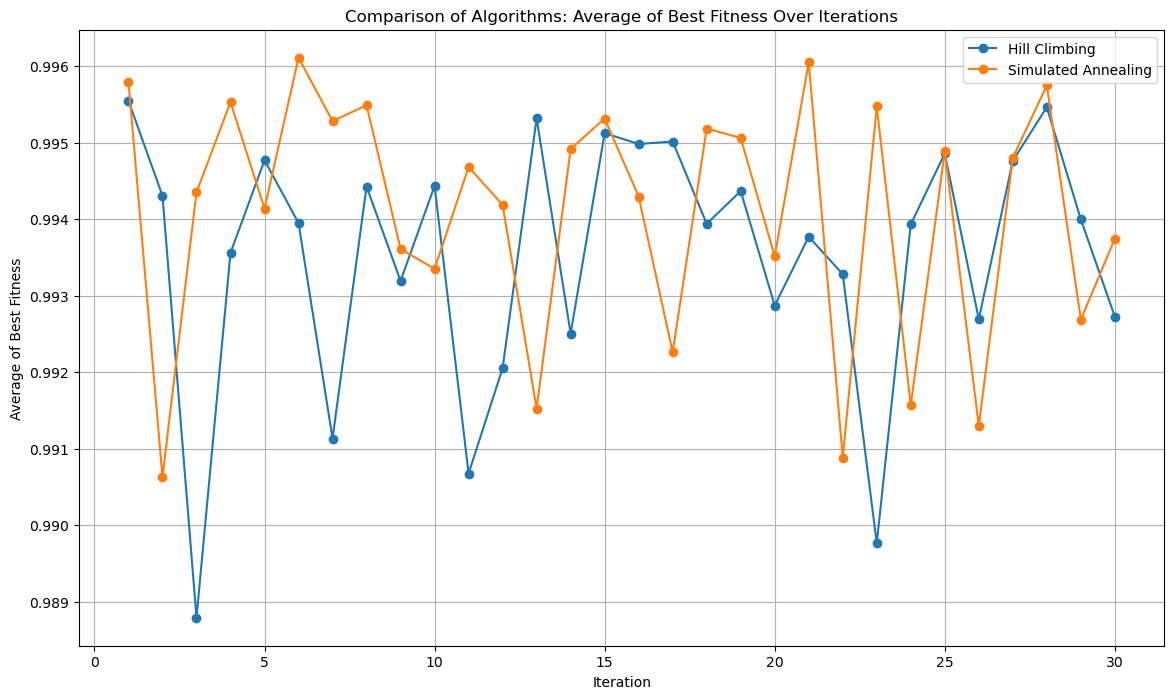

In [10]:
import matplotlib.pyplot as plt
import pandas as pd

# Data
data = {
    'Iteration': list(range(1, 31)),

    'Hill Climbing': [
        0.995548618, 0.994306302, 0.988789129, 0.993559944, 0.994772357,
        0.993949786, 0.991132516, 0.994426782, 0.993193312, 0.994436919,
        0.990674991, 0.992051727, 0.995319477, 0.99250469, 0.99512554,
        0.994984076, 0.995016373, 0.993940222, 0.994367937, 0.992871072,
        0.993771309, 0.993281123, 0.989762203, 0.993932804, 0.994860315,
        0.992691682, 0.994763238, 0.995465675, 0.993998752, 0.992724715
    ],
    'Simulated Annealing': [
        0.995797893, 0.990627092, 0.994351352, 0.995530857, 0.9941398,
        0.996111986, 0.995284084, 0.995490286, 0.993610741, 0.993351453,
        0.994682865, 0.994186951, 0.991523175, 0.994918102, 0.995316911,
        0.994296164, 0.992260746, 0.995186439, 0.995062631, 0.99351474,
        0.996054028, 0.990883498, 0.995477292, 0.991567343, 0.994889189,
        0.991297875, 0.994802605, 0.995750575, 0.992687875, 0.993743593
    ]
}

# Convert to DataFrame
df = pd.DataFrame(data)

# Plotting the data
plt.figure(figsize=(14, 8))


plt.plot(df['Iteration'], df['Hill Climbing'], label='Hill Climbing', marker='o')
plt.plot(df['Iteration'], df['Simulated Annealing'], label='Simulated Annealing', marker='o')

plt.xlabel('Iteration')
plt.ylabel('Average of Best Fitness')
plt.title('Comparison of Algorithms: Average of Best Fitness Over Iterations')
plt.legend()
plt.grid(True)

plt.show()


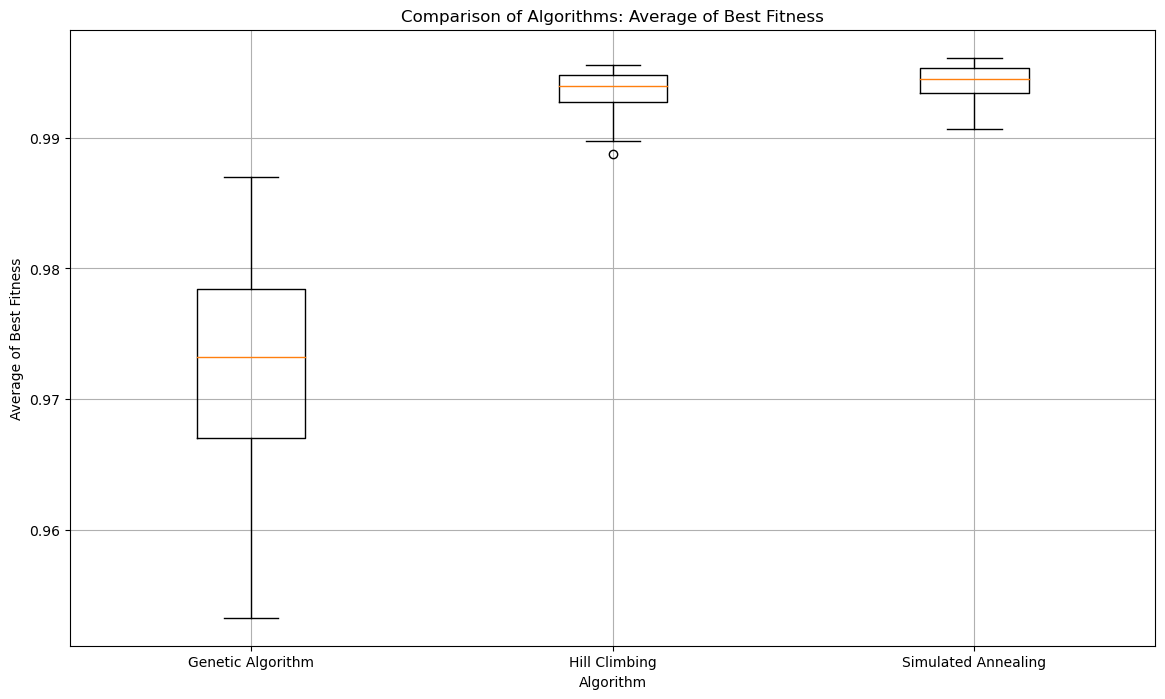

In [2]:
import matplotlib.pyplot as plt
import pandas as pd

# Data
data = {
    'Iteration': list(range(1, 31)),
    'Genetic Algorithm': [
        0.984305497, 0.986967512, 0.984624141, 0.978187428, 0.974360915,
        0.980241524, 0.98434613, 0.964507875, 0.977458471, 0.958452017,
        0.953297101, 0.969081476, 0.955612116, 0.959984801, 0.972063449,
        0.978893582, 0.973349264, 0.971128817, 0.961624624, 0.972685048,
        0.979744799, 0.978511338, 0.963220918, 0.973035609, 0.966978292,
        0.972505856, 0.967208796, 0.977561624, 0.974978417, 0.975424296
    ],
    'Hill Climbing': [
        0.995548618, 0.994306302, 0.988789129, 0.993559944, 0.994772357,
        0.993949786, 0.991132516, 0.994426782, 0.993193312, 0.994436919,
        0.990674991, 0.992051727, 0.995319477, 0.99250469, 0.99512554,
        0.994984076, 0.995016373, 0.993940222, 0.994367937, 0.992871072,
        0.993771309, 0.993281123, 0.989762203, 0.993932804, 0.994860315,
        0.992691682, 0.994763238, 0.995465675, 0.993998752, 0.992724715
    ],
    'Simulated Annealing': [
        0.995797893, 0.990627092, 0.994351352, 0.995530857, 0.9941398,
        0.996111986, 0.995284084, 0.995490286, 0.993610741, 0.993351453,
        0.994682865, 0.994186951, 0.991523175, 0.994918102, 0.995316911,
        0.994296164, 0.992260746, 0.995186439, 0.995062631, 0.99351474,
        0.996054028, 0.990883498, 0.995477292, 0.991567343, 0.994889189,
        0.991297875, 0.994802605, 0.995750575, 0.992687875, 0.993743593
    ]
}

# Convert to DataFrame
df = pd.DataFrame(data)

# Plotting the data
plt.figure(figsize=(14, 8))

# Create boxplot
plt.boxplot([df['Genetic Algorithm'], df['Hill Climbing'], df['Simulated Annealing']],
            labels=['Genetic Algorithm', 'Hill Climbing', 'Simulated Annealing'])

plt.xlabel('Algorithm')
plt.ylabel('Average of Best Fitness')
plt.title('Comparison of Algorithms: Average of Best Fitness')

plt.grid(True)
plt.show()


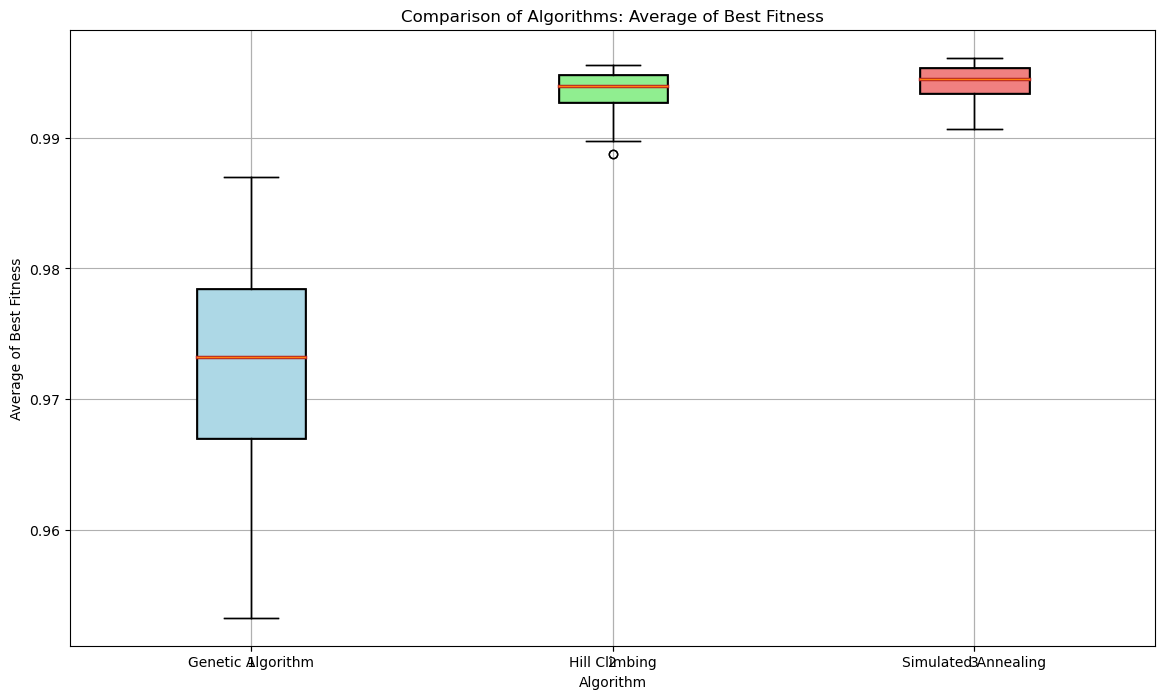

In [4]:
import matplotlib.pyplot as plt
import pandas as pd

# Data
data = {
    'Iteration': list(range(1, 31)),
    'Genetic Algorithm': [
        0.984305497, 0.986967512, 0.984624141, 0.978187428, 0.974360915,
        0.980241524, 0.98434613, 0.964507875, 0.977458471, 0.958452017,
        0.953297101, 0.969081476, 0.955612116, 0.959984801, 0.972063449,
        0.978893582, 0.973349264, 0.971128817, 0.961624624, 0.972685048,
        0.979744799, 0.978511338, 0.963220918, 0.973035609, 0.966978292,
        0.972505856, 0.967208796, 0.977561624, 0.974978417, 0.975424296
    ],
    'Hill Climbing': [
        0.995548618, 0.994306302, 0.988789129, 0.993559944, 0.994772357,
        0.993949786, 0.991132516, 0.994426782, 0.993193312, 0.994436919,
        0.990674991, 0.992051727, 0.995319477, 0.99250469, 0.99512554,
        0.994984076, 0.995016373, 0.993940222, 0.994367937, 0.992871072,
        0.993771309, 0.993281123, 0.989762203, 0.993932804, 0.994860315,
        0.992691682, 0.994763238, 0.995465675, 0.993998752, 0.992724715
    ],
    'Simulated Annealing': [
        0.995797893, 0.990627092, 0.994351352, 0.995530857, 0.9941398,
        0.996111986, 0.995284084, 0.995490286, 0.993610741, 0.993351453,
        0.994682865, 0.994186951, 0.991523175, 0.994918102, 0.995316911,
        0.994296164, 0.992260746, 0.995186439, 0.995062631, 0.99351474,
        0.996054028, 0.990883498, 0.995477292, 0.991567343, 0.994889189,
        0.991297875, 0.994802605, 0.995750575, 0.992687875, 0.993743593
    ]
}

# Convert to DataFrame
df = pd.DataFrame(data)

# Plotting the data
plt.figure(figsize=(14, 8))

# Create boxplot with colors
boxprops = dict(linestyle='-', linewidth=2, color='black')
medianprops = dict(linestyle='-', linewidth=2.5, color='firebrick')
colors = ['lightblue', 'lightgreen', 'lightcoral']

plt.boxplot([df['Genetic Algorithm'], df['Hill Climbing'], df['Simulated Annealing']],
            labels=['Genetic Algorithm', 'Hill Climbing', 'Simulated Annealing'],
            patch_artist=True,
            boxprops=boxprops,
            medianprops=medianprops)

# Add colors to the boxes
for patch, color in zip(plt.boxplot([df['Genetic Algorithm'], df['Hill Climbing'], df['Simulated Annealing']],
                                    patch_artist=True)['boxes'], colors):
    patch.set_facecolor(color)

plt.xlabel('Algorithm')
plt.ylabel('Average of Best Fitness')
plt.title('Comparison of Algorithms: Average of Best Fitness')

plt.grid(True)
plt.show()


# SIMULATED ANNEALING

In [1]:
import tkinter as tk
from tkinter import filedialog, messagebox, scrolledtext
from tkinter import ttk
import pandas as pd
import csv
import random
import threading
import time
import copy
import numpy as np

class AllocationApp:
    def __init__(self, root):
        self.root = root
        self.root.title("Student Allocation App")
        self.root.geometry("800x600")
        self.root.state('zoomed')  # Start maximized

        # Set theme and style
        self.style = ttk.Style()
        self.style.theme_use('clam')  # Use the 'clam' theme for a modern look
        self.style.configure('TFrame', background='#e0f7fa')
        self.style.configure('TLabel', background='#e0f7fa', font=('Helvetica', 10))
        self.style.configure('TButton', font=('Helvetica', 10), padding=6, background='#00796b', foreground='#ffffff')
        self.style.configure('TLabelFrame', background='#b2ebf2', font=('Helvetica', 12, 'bold'))
        self.style.configure('TScrolledText', background='#ffffff')

        self.lecturer_file_path = ""
        self.csc_file_path = ""
        self.mis_file_path = ""
        self.allocations = None
        self.csc_students_df = None
        self.mis_students_df = None
        self.create_widgets()

    def create_widgets(self):
        main_frame = ttk.Frame(self.root, padding="10")
        main_frame.grid(row=0, column=0, sticky=(tk.W, tk.E, tk.N, tk.S))
        self.root.grid_rowconfigure(0, weight=1)
        self.root.grid_columnconfigure(0, weight=1)

        file_frame = ttk.Frame(main_frame, padding="10", relief='sunken')
        file_frame.grid(row=0, column=0, pady=10, sticky=tk.EW)
        main_frame.grid_columnconfigure(0, weight=1)

        lecturer_frame = ttk.LabelFrame(file_frame, text="Lecturer Data", padding="10")
        lecturer_frame.grid(row=0, column=0, padx=5, pady=5, sticky=tk.W)
        self.lecturer_button = ttk.Button(lecturer_frame, text="Browse", command=self.upload_lecturer_file)
        self.lecturer_button.grid(row=0, column=0, padx=5, pady=5)
        self.lecturer_label = ttk.Label(lecturer_frame, text="No file selected")
        self.lecturer_label.grid(row=0, column=1, padx=5, pady=5)

        csc_frame = ttk.LabelFrame(file_frame, text="CSC Student Data", padding="10")
        csc_frame.grid(row=0, column=1, padx=5, pady=5, sticky=tk.W)
        self.csc_button = ttk.Button(csc_frame, text="Browse", command=self.upload_csc_file)
        self.csc_button.grid(row=0, column=0, padx=5, pady=5)
        self.csc_label = ttk.Label(csc_frame, text="No file selected")
        self.csc_label.grid(row=0, column=1, padx=5, pady=5)

        mis_frame = ttk.LabelFrame(file_frame, text="MIS Student Data", padding="10")
        mis_frame.grid(row=0, column=2, padx=5, pady=5, sticky=tk.W)
        self.mis_button = ttk.Button(mis_frame, text="Browse", command=self.upload_mis_file)
        self.mis_button.grid(row=0, column=0, padx=5, pady=5)
        self.mis_label = ttk.Label(mis_frame, text="No file selected")
        self.mis_label.grid(row=0, column=1, padx=5, pady=5)

        action_frame = ttk.Frame(main_frame, padding="10", relief='sunken')
        action_frame.grid(row=1, column=0, pady=10, sticky=tk.EW)
        main_frame.grid_rowconfigure(1, weight=0)

        self.allocate_button = ttk.Button(action_frame, text="Allocate Students", command=self.run_allocation)
        self.allocate_button.grid(row=0, column=0, padx=5, pady=5)

        self.export_button = ttk.Button(action_frame, text="Export Allocation to CSV", command=self.export_to_csv)
        self.export_button.grid(row=0, column=1, padx=5, pady=5)
        self.export_button.state(['disabled'])

        result_frame = ttk.LabelFrame(main_frame, text="Allocation Results", padding="10")
        result_frame.grid(row=2, column=0, pady=10, sticky=(tk.W, tk.E, tk.N, tk.S))
        self.result_text = scrolledtext.ScrolledText(result_frame, wrap=tk.WORD, bg='#ffffff', fg='#000000')
        self.result_text.grid(row=0, column=0, padx=5, pady=5, sticky=(tk.W, tk.E, tk.N, tk.S))
        self.result_text.configure(font=('Helvetica', 10))

        result_frame.grid_rowconfigure(0, weight=1)
        result_frame.grid_columnconfigure(0, weight=1)
        main_frame.grid_rowconfigure(2, weight=1)

    def upload_lecturer_file(self):
        self.lecturer_file_path = filedialog.askopenfilename(filetypes=[("CSV files", "*.csv")])
        if self.lecturer_file_path:
            self.lecturer_label.config(text=self.lecturer_file_path.split('/')[-1])
            messagebox.showinfo("File Selected", f"Lecturer File: {self.lecturer_file_path}")

    def upload_csc_file(self):
        self.csc_file_path = filedialog.askopenfilename(filetypes=[("CSV files", "*.csv")])
        if self.csc_file_path:
            self.csc_label.config(text=self.csc_file_path.split('/')[-1])
            messagebox.showinfo("File Selected", f"CSC Student File: {self.csc_file_path}")

    def upload_mis_file(self):
        self.mis_file_path = filedialog.askopenfilename(filetypes=[("CSV files", "*.csv")])
        if self.mis_file_path:
            self.mis_label.config(text=self.mis_file_path.split('/')[-1])
            messagebox.showinfo("File Selected", f"MIS Student File: {self.mis_file_path}")

    def run_allocation(self):
        thread = threading.Thread(target=self.allocate_students)
        thread.start()

    def classify_student(self, student):
        cgpa = student["CGPA"]
        if 4.5 <= cgpa < 5.0:
            return "first_class"
        elif 3.5 <= cgpa < 4.5:
            return "second_class_upper"
        elif 2.5 <= cgpa < 3.5:
            return "second_class_lower"
        else:
            return "third_class"

    def allocate_students(self):
        if not (self.lecturer_file_path and self.csc_file_path and self.mis_file_path):
            self.show_messagebox("Error", "Please upload all required files.")
            return

        start_time = time.time()
        time_limit = 3 * 60  # 3 minutes

        try:
            print("Loading CSV files...")
            lecturers_df = pd.read_csv(self.lecturer_file_path)
            self.csc_students_df = pd.read_csv(self.csc_file_path)
            self.mis_students_df = pd.read_csv(self.mis_file_path)
            # Add 'Course' column to student dataframes
            self.csc_students_df['Course'] = 'CSC'
            self.mis_students_df['Course'] = 'MIS'
            load_time = time.time()
            print(f"CSV files loaded in {load_time - start_time:.2f} seconds")

            cadre_to_rank = {
                'Professor': 9,
                'Assc. Professor': 8,
                'Senior Lecturer': 7,
                'Lecturer 1': 6,
                'Lecturer 2': 5,
                'AL1': 4,
                'AL2': 3,
                'AL3': 2,
                'AL4': 1
            }

            lecturers = [
                {"name": row['Name'], "rank": cadre_to_rank[row['Cadre']]}
                for index, row in lecturers_df.iterrows()
            ]

            csc_students = self.csc_students_df[['Name', 'Matric. No.', 'CGPA', 'Course']].to_dict('records')
            mis_students = self.mis_students_df[['Name', 'Matric. No.', 'CGPA', 'Course']].to_dict('records')

            total_lecturer_rank = sum(lecturer["rank"] for lecturer in lecturers)
            total_students = len(csc_students) + len(mis_students)

            for lecturer in lecturers:
                lecturer['ideal_allocation'] = int(round(lecturer["rank"] / total_lecturer_rank * total_students))
                lecturer['ideal_csc'] = int(round(lecturer["rank"] / total_lecturer_rank * len(csc_students)))
                lecturer['ideal_mis'] = int(round(lecturer["rank"] / total_lecturer_rank * len(mis_students)))

            lecturers.sort(key=lambda l: l["rank"], reverse=True)

            def allocate_students_by_course(students, ideal_allocations):
                allocation = {lecturer["name"]: [] for lecturer in lecturers}
                student_index = 0
                for lecturer in lecturers:
                    for _ in range(ideal_allocations[lecturer["name"]]):
                        if student_index >= len(students):
                            break
                        student = students[student_index]
                        allocation[lecturer["name"]].append(student)
                        student_index += 1
                return allocation

            print("Allocating CSC students...")
            csc_ideal_allocations = {lecturer["name"]: lecturer["ideal_csc"] for lecturer in lecturers}
            csc_allocation = allocate_students_by_course(csc_students, csc_ideal_allocations)

            print("Allocating MIS students...")
            mis_ideal_allocations = {lecturer["name"]: lecturer["ideal_mis"] for lecturer in lecturers}
            mis_allocation = allocate_students_by_course(mis_students, mis_ideal_allocations)

            combined_allocation = {lecturer["name"]: {"students": [], "CSC": 0, "MIS": 0} for lecturer in lecturers}

            for lecturer in lecturers:
                combined_allocation[lecturer["name"]]["students"] = csc_allocation[lecturer["name"]] + mis_allocation[lecturer["name"]]
                combined_allocation[lecturer["name"]]["CSC"] = len(csc_allocation[lecturer["name"]])
                combined_allocation[lecturer["name"]]["MIS"] = len(mis_allocation[lecturer["name"]])

            initial_allocation = copy.deepcopy(combined_allocation)

            def calculate_fitness(allocation):
                average_cgpas = np.array([np.mean([student["CGPA"] for student in data["students"]]) if data["students"] else 0 for data in allocation.values()])
                overall_average_cgpa = np.mean(average_cgpas) if len(average_cgpas) > 0 else 0
                fitness = 1 / (1 + np.sqrt(np.sum((average_cgpas - overall_average_cgpa) ** 2)))
                return fitness

            def mutate(allocation):
                lecturer1, lecturer2 = random.sample(list(allocation.keys()), 2)
                course = random.choice(["CSC", "MIS"])
                if allocation[lecturer1]["students"] and allocation[lecturer2]["students"]:
                    students1 = [student for student in allocation[lecturer1]["students"] if student["Course"] == course]
                    students2 = [student for student in allocation[lecturer2]["students"] if student["Course"] == course]
                    if students1 and students2:
                        student1 = random.choice(students1)
                        student2 = random.choice(students2)
                        allocation[lecturer1]["students"].remove(student1)
                        allocation[lecturer2]["students"].remove(student2)
                        allocation[lecturer1]["students"].append(student2)
                        allocation[lecturer2]["students"].append(student1)
                return allocation

            def simulated_annealing(initial_allocation, max_iter, initial_temp, cooling_rate):
                current_allocation = copy.deepcopy(initial_allocation)
                current_fitness = calculate_fitness(current_allocation)
                best_allocation = copy.deepcopy(current_allocation)
                best_fitness = current_fitness

                temp = initial_temp
                for i in range(max_iter):
                    if time.time() - start_time > time_limit:
                        print(f"Time limit reached at iteration {i + 1}")
                        break
                    new_allocation = mutate(copy.deepcopy(current_allocation))
                    new_fitness = calculate_fitness(new_allocation)
                    try:
                        acceptance_probability = np.exp((new_fitness - current_fitness) / temp)
                    except OverflowError:
                        acceptance_probability = float('inf')
                    if new_fitness > current_fitness or random.uniform(0, 1) < acceptance_probability:
                        current_allocation = new_allocation
                        current_fitness = new_fitness
                        if new_fitness > best_fitness:
                            best_allocation = new_allocation
                            best_fitness = new_fitness
                    temp *= cooling_rate
                return best_allocation

            max_iter = 1000000  # Large number to ensure the loop is governed by the time limit
            initial_temp = 100
            cooling_rate = 0.99

            print("Starting simulated annealing optimization...")
            best_allocation = simulated_annealing(initial_allocation, max_iter, initial_temp, cooling_rate)
            best_fitness = calculate_fitness(best_allocation)
            print(f"Simulated annealing optimization complete with Best Fitness: {best_fitness:.4f}")

            self.allocations = best_allocation

            self.root.after(0, self.export_button.state, ['!disabled'])
            self.root.after(0, self.display_results, self.allocations)

            # Print the average CGPA of all lecturers
            avg_cgpas = [sum(student["CGPA"] for student in data["students"]) / len(data["students"]) if data["students"] else 0 for data in best_allocation.values()]
            overall_avg_cgpa = sum(avg_cgpas) / len(avg_cgpas) if avg_cgpas else 0
            print(f"Overall Average CGPA of all lecturers: {overall_avg_cgpa:.8f}")

            end_time = time.time()
            print(f"Load time: {load_time - start_time:.2f} seconds")
            print(f"Total time: {end_time - start_time:.2f} seconds")

        except Exception as e:
            self.show_messagebox("Error", f"An error occurred: {str(e)}")

    def show_messagebox(self, title, message):
        self.root.after(0, messagebox.showerror, title, message)

    def display_results(self, allocations):
        self.result_text.delete(1.0, tk.END)
        for lecturer, data in allocations.items():
            self.result_text.insert(tk.END, f"{lecturer}:\n")
            self.result_text.insert(tk.END, f"\tTotal Students: {len(data['students'])}\n")
            self.result_text.insert(tk.END, f"\tCSC Students: {data['CSC']}\n")
            self.result_text.insert(tk.END, f"\tMIS Students: {data['MIS']}\n")
            classified_students = {"first_class": [], "second_class_upper": [], "second_class_lower": [], "third_class": []}
            for student in data["students"]:
                student_class = self.classify_student(student)
                classified_students[student_class].append(student)
            for class_name, students in classified_students.items():
                self.result_text.insert(tk.END, f"\t{class_name.replace('_', ' ').title()}:\n")
                for student in students:
                    self.result_text.insert(tk.END, f"\t\t- {student['Name']} (CGPA: {student['CGPA']}, Course: {student['Course']})\n")
            total_cgpa = sum(student["CGPA"] for student in data["students"])
            average_cgpa = total_cgpa / len(data["students"]) if len(data["students"]) > 0 else 0
            self.result_text.insert(tk.END, f"\tAverage CGPA: {average_cgpa:.2f}\n\n")

    def export_to_csv(self):
        if not self.allocations:
            messagebox.showerror("Error", "No allocation data to export.")
            return

        file_path = filedialog.asksaveasfilename(defaultextension=".csv", filetypes=[("CSV files", "*.csv")])
        if not file_path:
            return

        try:
            with open(file_path, mode='w', newline='') as file:
                writer = csv.writer(file)
                writer.writerow(["Lecturer", "Total Students", "Class", "Student Name", "CGPA", "Course"])
                for lecturer, data in self.allocations.items():
                    classified_students = {"first_class": [], "second_class_upper": [], "second_class_lower": [], "third_class": []}
                    for student in data["students"]:
                        student_class = self.classify_student(student)
                        classified_students[student_class].append(student)
                    for class_name, students in classified_students.items():
                        for student in students:
                            writer.writerow([lecturer, len(data["students"]), class_name.replace('_', ' ').title(), student['Name'], student['CGPA'], student['Course']])

            messagebox.showinfo("Success", f"Allocations exported to {file_path}")
        except Exception as e:
            messagebox.showerror("Error", f"An error occurred while exporting: {str(e)}")

if __name__ == "__main__":
    root = tk.Tk()
    app = AllocationApp(root)
    root.mainloop()


Loading CSV files...
CSV files loaded in 0.09 seconds
Allocating CSC students...
Allocating MIS students...
Starting simulated annealing optimization...


C:\Users\ELITEBOOK 840 G3\AppData\Local\Temp\ipykernel_3864\772686052.py:234: RuntimeWarning: overflow encountered in exp
  acceptance_probability = np.exp((new_fitness - current_fitness) / temp)


Time limit reached at iteration 49094
Simulated annealing optimization complete with Best Fitness: 0.9954
Overall Average CGPA of all lecturers: 3.86148447
Load time: 0.09 seconds
Total time: 180.00 seconds


# GENETIC ALGORITHM

In [ ]:
import tkinter as tk
from tkinter import filedialog, messagebox, scrolledtext
from tkinter import ttk
import pandas as pd
import csv
import random
import threading
import time
import copy
import numpy as np
import concurrent.futures

class AllocationApp:
    def __init__(self, root):
        self.root = root
        self.root.title("Student Allocation App")
        self.root.geometry("800x600")
        self.root.state('zoomed')  # Start maximized

        # Set theme and style
        self.style = ttk.Style()
        self.style.theme_use('clam')  # Use the 'clam' theme for a modern look
        self.style.configure('TFrame', background='#e0f7fa')
        self.style.configure('TLabel', background='#e0f7fa', font=('Helvetica', 10))
        self.style.configure('TButton', font=('Helvetica', 10), padding=6, background='#00796b', foreground='#ffffff')
        self.style.configure('TLabelFrame', background='#b2ebf2', font=('Helvetica', 12, 'bold'))
        self.style.configure('TScrolledText', background='#ffffff')

        self.lecturer_file_path = ""
        self.csc_file_path = ""
        self.mis_file_path = ""
        self.allocations = None
        self.csc_students_df = None
        self.mis_students_df = None
        self.create_widgets()

    def create_widgets(self):
        main_frame = ttk.Frame(self.root, padding="10")
        main_frame.grid(row=0, column=0, sticky=(tk.W, tk.E, tk.N, tk.S))
        self.root.grid_rowconfigure(0, weight=1)
        self.root.grid_columnconfigure(0, weight=1)

        file_frame = ttk.Frame(main_frame, padding="10", relief='sunken')
        file_frame.grid(row=0, column=0, pady=10, sticky=tk.EW)
        main_frame.grid_columnconfigure(0, weight=1)

        lecturer_frame = ttk.LabelFrame(file_frame, text="Lecturer Data", padding="10")
        lecturer_frame.grid(row=0, column=0, padx=5, pady=5, sticky=tk.W)
        self.lecturer_button = ttk.Button(lecturer_frame, text="Browse", command=self.upload_lecturer_file)
        self.lecturer_button.grid(row=0, column=0, padx=5, pady=5)
        self.lecturer_label = ttk.Label(lecturer_frame, text="No file selected")
        self.lecturer_label.grid(row=0, column=1, padx=5, pady=5)

        csc_frame = ttk.LabelFrame(file_frame, text="CSC Student Data", padding="10")
        csc_frame.grid(row=0, column=1, padx=5, pady=5, sticky=tk.W)
        self.csc_button = ttk.Button(csc_frame, text="Browse", command=self.upload_csc_file)
        self.csc_button.grid(row=0, column=0, padx=5, pady=5)
        self.csc_label = ttk.Label(csc_frame, text="No file selected")
        self.csc_label.grid(row=0, column=1, padx=5, pady=5)

        mis_frame = ttk.LabelFrame(file_frame, text="MIS Student Data", padding="10")
        mis_frame.grid(row=0, column=2, padx=5, pady=5, sticky=tk.W)
        self.mis_button = ttk.Button(mis_frame, text="Browse", command=self.upload_mis_file)
        self.mis_button.grid(row=0, column=0, padx=5, pady=5)
        self.mis_label = ttk.Label(mis_frame, text="No file selected")
        self.mis_label.grid(row=0, column=1, padx=5, pady=5)

        action_frame = ttk.Frame(main_frame, padding="10", relief='sunken')
        action_frame.grid(row=1, column=0, pady=10, sticky=tk.EW)
        main_frame.grid_rowconfigure(1, weight=0)

        self.allocate_button = ttk.Button(action_frame, text="Allocate Students", command=self.run_allocation)
        self.allocate_button.grid(row=0, column=0, padx=5, pady=5)

        self.export_button = ttk.Button(action_frame, text="Export Allocation to CSV", command=self.export_to_csv)
        self.export_button.grid(row=0, column=1, padx=5, pady=5)
        self.export_button.state(['disabled'])

        result_frame = ttk.LabelFrame(main_frame, text="Allocation Results", padding="10")
        result_frame.grid(row=2, column=0, pady=10, sticky=(tk.W, tk.E, tk.N, tk.S))
        self.result_text = scrolledtext.ScrolledText(result_frame, wrap=tk.WORD, bg='#ffffff', fg='#000000')
        self.result_text.grid(row=0, column=0, padx=5, pady=5, sticky=(tk.W, tk.E, tk.N, tk.S))
        self.result_text.configure(font=('Helvetica', 10))

        result_frame.grid_rowconfigure(0, weight=1)
        result_frame.grid_columnconfigure(0, weight=1)
        main_frame.grid_rowconfigure(2, weight=1)

    def upload_lecturer_file(self):
        self.lecturer_file_path = filedialog.askopenfilename(filetypes=[("CSV files", "*.csv")])
        if self.lecturer_file_path:
            self.lecturer_label.config(text=self.lecturer_file_path.split('/')[-1])
            messagebox.showinfo("File Selected", f"Lecturer File: {self.lecturer_file_path}")

    def upload_csc_file(self):
        self.csc_file_path = filedialog.askopenfilename(filetypes=[("CSV files", "*.csv")])
        if self.csc_file_path:
            self.csc_label.config(text=self.csc_file_path.split('/')[-1])
            messagebox.showinfo("File Selected", f"CSC Student File: {self.csc_file_path}")

    def upload_mis_file(self):
        self.mis_file_path = filedialog.askopenfilename(filetypes=[("CSV files", "*.csv")])
        if self.mis_file_path:
            self.mis_label.config(text=self.mis_file_path.split('/')[-1])
            messagebox.showinfo("File Selected", f"MIS Student File: {self.mis_file_path}")

    def run_allocation(self):
        thread = threading.Thread(target=self.allocate_students)
        thread.start()

    def classify_student(self, student):
        cgpa = student["CGPA"]
        if cgpa >= 4.5:
            return "first_class"
        elif 3.5 <= cgpa < 4.5:
            return "second_class_upper"
        elif 2.5 <= cgpa < 3.5:
            return "second_class_lower"
        else:
            return "third_class"

    def allocate_students(self):
        if not (self.lecturer_file_path and self.csc_file_path and self.mis_file_path):
            self.show_messagebox("Error", "Please upload all required files.")
            return

        start_time = time.time()
        time_limit = 3 * 60  # 3 minutes

        try:
            print("Loading CSV files...")
            lecturers_df = pd.read_csv(self.lecturer_file_path)
            self.csc_students_df = pd.read_csv(self.csc_file_path)
            self.mis_students_df = pd.read_csv(self.mis_file_path)

            # Add 'Course' column to student dataframes
            self.csc_students_df['Course'] = 'CSC'
            self.mis_students_df['Course'] = 'MIS'

            load_time = time.time()
            print(f"CSV files loaded in {load_time - start_time:.2f} seconds")

            cadre_to_rank = {
                'Professor': 9,
                'Assc. Professor': 8,
                'Senior Lecturer': 7,
                'Lecturer 1': 6,
                'Lecturer 2': 5,
                'AL1': 4,
                'AL2': 3,
                'AL3': 2,
                'AL4': 1
            }

            lecturers = [
                {"name": row['Name'], "rank": cadre_to_rank[row['Cadre']]}
                for index, row in lecturers_df.iterrows()
            ]

            csc_students = self.csc_students_df[['Name', 'Matric. No.', 'CGPA', 'Course']].to_dict('records')
            mis_students = self.mis_students_df[['Name', 'Matric. No.', 'CGPA', 'Course']].to_dict('records')

            total_lecturer_rank = sum(lecturer["rank"] for lecturer in lecturers)
            total_students = len(csc_students) + len(mis_students)

            for lecturer in lecturers:
                lecturer['ideal_allocation'] = int(round(lecturer["rank"] / total_lecturer_rank * total_students))
                lecturer['ideal_csc'] = int(round(lecturer["rank"] / total_lecturer_rank * len(csc_students)))
                lecturer['ideal_mis'] = int(round(lecturer["rank"] / total_lecturer_rank * len(mis_students)))

            lecturers.sort(key=lambda l: l["rank"], reverse=True)

            def allocate_students_by_course(students, ideal_allocations):
                allocation = {lecturer["name"]: [] for lecturer in lecturers}
                student_index = 0
                for lecturer in lecturers:
                    for _ in range(ideal_allocations[lecturer["name"]]):
                        if student_index >= len(students):
                            break
                        student = students[student_index]
                        allocation[lecturer["name"]].append(student)
                        student_index += 1
                return allocation

            print("Allocating CSC students...")
            csc_ideal_allocations = {lecturer["name"]: lecturer["ideal_csc"] for lecturer in lecturers}
            csc_allocation = allocate_students_by_course(csc_students, csc_ideal_allocations)

            print("Allocating MIS students...")
            mis_ideal_allocations = {lecturer["name"]: lecturer["ideal_mis"] for lecturer in lecturers}
            mis_allocation = allocate_students_by_course(mis_students, mis_ideal_allocations)

            combined_allocation = {lecturer["name"]: {"students": [], "CSC": 0, "MIS": 0} for lecturer in lecturers}

            for lecturer in lecturers:
                combined_allocation[lecturer["name"]]["students"] = csc_allocation[lecturer["name"]] + mis_allocation[lecturer["name"]]
                combined_allocation[lecturer["name"]]["CSC"] = len(csc_allocation[lecturer["name"]])
                combined_allocation[lecturer["name"]]["MIS"] = len(mis_allocation[lecturer["name"]])

            initial_allocation = copy.deepcopy(combined_allocation)

            def calculate_fitness(allocation):
                average_cgpas = np.array([np.mean([student["CGPA"] for student in data["students"]]) if data["students"] else 0 for data in allocation.values()])
                overall_average_cgpa = np.mean(average_cgpas) if len(average_cgpas) > 0 else 0
                fitness = 1 / (1 + np.sqrt(np.sum((average_cgpas - overall_average_cgpa) ** 2)))
                return fitness

            def initialize_population(size):
                population = []
                for _ in range(size):
                    allocation = copy.deepcopy(initial_allocation)
                    for lecturer in lecturers:
                        random.shuffle(allocation[lecturer["name"]]["students"])
                    population.append(allocation)
                return population

            def tournament_selection(population, k=3):
                selected = []
                for _ in range(len(population)):
                    aspirants = random.sample(population, k)
                    selected.append(max(aspirants, key=calculate_fitness))
                return selected

            def crossover(parent1, parent2):
                child1, child2 = copy.deepcopy(parent1), copy.deepcopy(parent2)
                for lecturer in parent1.keys():
                    if random.random() > 0.5:
                        child1[lecturer], child2[lecturer] = child2[lecturer], child1[lecturer]
                return child1, child2

            def mutate(allocation, mutation_rate=0.1):
                if random.random() < mutation_rate:
                    lecturer1, lecturer2 = random.sample(list(allocation.keys()), 2)
                    if allocation[lecturer1]["students"] and allocation[lecturer2]["students"]:
                        student1 = random.choice(allocation[lecturer1]["students"])
                        student2 = random.choice(allocation[lecturer2]["students"])
                        allocation[lecturer1]["students"].remove(student1)
                        allocation[lecturer2]["students"].remove(student2)
                        allocation[lecturer1]["students"].append(student2)
                        allocation[lecturer2]["students"].append(student1)
                return allocation

            def adaptive_mutation_rate(population, base_rate=0.1):
                unique_individuals = len(set(tuple(sorted(ind.keys())) for ind in population))
                diversity_ratio = unique_individuals / len(population)
                return base_rate * (1 + diversity_ratio)

            def local_search(allocation):
                best_allocation = copy.deepcopy(allocation)
                best_fitness = calculate_fitness(best_allocation)
                for _ in range(80):  # Reduced iterations for faster local search
                    mutated_allocation = mutate(copy.deepcopy(allocation), mutation_rate=1)
                    mutated_fitness = calculate_fitness(mutated_allocation)
                    if mutated_fitness > best_fitness:
                        best_allocation = mutated_allocation
                        best_fitness = mutated_fitness
                return best_allocation

            def evaluate_population_fitness(population):
                with concurrent.futures.ThreadPoolExecutor() as executor:
                    fitness_values = list(executor.map(calculate_fitness, population))
                return fitness_values

            population_size = 45  # Reduced for faster execution
            generations = 1000000  # Large number to ensure the loop is governed by the time limit
            population = initialize_population(population_size)
            elitism_rate = 0.1

            print("Starting genetic algorithm optimization...")
            for generation in range(generations):
                if time.time() - start_time > time_limit:
                    print(f"Time limit reached at generation {generation + 1}")
                    break

                population_fitness = evaluate_population_fitness(population)
                sorted_population = [x for _, x in sorted(zip(population_fitness, population), key=lambda pair: pair[0], reverse=True)]
                population = sorted_population[:int(elitism_rate * population_size)]  # Elitism

                new_population = population[:]
                while len(new_population) < population_size:
                    parent1, parent2 = random.sample(population, 2)
                    child1, child2 = crossover(parent1, parent2)
                    mutation_rate = adaptive_mutation_rate(population)
                    new_population.extend([mutate(child1, mutation_rate), mutate(child2, mutation_rate)])

                new_population = new_population[:population_size]
                population = new_population
                population = [local_search(ind) for ind in population]
                best_allocation = max(population, key=calculate_fitness)
                best_fitness = calculate_fitness(best_allocation)
                print(f"Generation {generation + 1}/{generations} - Best Fitness: {best_fitness:.4f}")

            print("Genetic algorithm optimization complete")

            self.allocations = best_allocation

            self.root.after(0, self.export_button.state, ['!disabled'])
            self.root.after(0, self.display_results, self.allocations)

            # Print the average CGPA of all lecturers
            avg_cgpas = [sum(student["CGPA"] for student in data["students"]) / len(data["students"]) if data["students"] else 0 for data in best_allocation.values()]
            overall_avg_cgpa = sum(avg_cgpas) / len(avg_cgpas) if avg_cgpas else 0
            print(f"Overall Average CGPA of all lecturers: {overall_avg_cgpa:.8f}")

            end_time = time.time()
            print(f"Load time: {load_time - start_time:.2f} seconds")
            print(f"Total time: {end_time - start_time:.2f} seconds")

        except Exception as e:
            self.show_messagebox("Error", f"An error occurred: {str(e)}")

    def show_messagebox(self, title, message):
        self.root.after(0, messagebox.showerror, title, message)

    def display_results(self, allocations):
        self.result_text.delete(1.0, tk.END)
        for lecturer, data in allocations.items():
            self.result_text.insert(tk.END, f"{lecturer}:\n")
            self.result_text.insert(tk.END, f"\tTotal Students: {len(data['students'])}\n")
            self.result_text.insert(tk.END, f"\tCSC Students: {data['CSC']}\n")
            self.result_text.insert(tk.END, f"\tMIS Students: {data['MIS']}\n")
            classified_students = {"first_class": [], "second_class_upper": [], "second_class_lower": [], "third_class": []}
            for student in data["students"]:
                student_class = self.classify_student(student)
                classified_students[student_class].append(student)
            for class_name, students in classified_students.items():
                self.result_text.insert(tk.END, f"\t{class_name.replace('_', ' ').title()}:\n")
                for student in students:
                    self.result_text.insert(tk.END, f"\t\t- {student['Name']} (CGPA: {student['CGPA']})\n")
            total_cgpa = sum(student["CGPA"] for student in data["students"])
            average_cgpa = total_cgpa / len(data["students"]) if len(data["students"]) > 0 else 0
            self.result_text.insert(tk.END, f"\tAverage CGPA: {average_cgpa:.2f}\n\n")

    def export_to_csv(self):
        if not self.allocations:
            messagebox.showerror("Error", "No allocation data to export.")
            return

        file_path = filedialog.asksaveasfilename(defaultextension=".csv", filetypes=[("CSV files", "*.csv")])
        if not file_path:
            return

        try:
            with open(file_path, mode='w', newline='') as file:
                writer = csv.writer(file)
                writer.writerow(["Lecturer", "Total Students", "Class", "Student Name", "CGPA", "Course"])
                for lecturer, data in self.allocations.items():
                    classified_students = {"first_class": [], "second_class_upper": [], "second_class_lower": [], "third_class": []}
                    for student in data["students"]:
                        student_class = self.classify_student(student)
                        classified_students[student_class].append(student)
                    for class_name, students in classified_students.items():
                        for student in students:
                            writer.writerow([lecturer, len(data["students"]), class_name.replace('_', ' ').title(), student['Name'], student['CGPA'], student['Course']])

            messagebox.showinfo("Success", f"Allocations exported to {file_path}")
        except Exception as e:
            messagebox.showerror("Error", f"An error occurred while exporting: {str(e)}")

if __name__ == "__main__":
    root = tk.Tk()
    app = AllocationApp(root)
    root.mainloop()


Loading CSV files...
CSV files loaded in 0.09 seconds
Allocating CSC students...
Allocating MIS students...
Starting genetic algorithm optimization...
Generation 1/1000000 - Best Fitness: 0.2580
Generation 2/1000000 - Best Fitness: 0.2927
Generation 3/1000000 - Best Fitness: 0.3260
Generation 4/1000000 - Best Fitness: 0.3702
Generation 5/1000000 - Best Fitness: 0.4034
Generation 6/1000000 - Best Fitness: 0.4521
Generation 7/1000000 - Best Fitness: 0.4933
Generation 8/1000000 - Best Fitness: 0.5535
Generation 9/1000000 - Best Fitness: 0.5951
Generation 10/1000000 - Best Fitness: 0.6559
Generation 11/1000000 - Best Fitness: 0.7112
Generation 12/1000000 - Best Fitness: 0.7549
Generation 13/1000000 - Best Fitness: 0.7924
Generation 14/1000000 - Best Fitness: 0.8293
Generation 15/1000000 - Best Fitness: 0.8571
Generation 16/1000000 - Best Fitness: 0.8764
Generation 17/1000000 - Best Fitness: 0.9010
Generation 18/1000000 - Best Fitness: 0.9293
Generation 19/1000000 - Best Fitness: 0.9379
Gen

# HILL CLIMBING 

In [13]:
import tkinter as tk
from tkinter import filedialog, messagebox, scrolledtext
from tkinter import ttk
import pandas as pd
import csv
import random
import threading
import time
import copy
import numpy as np

class AllocationApp:
    def __init__(self, root):
        self.root = root
        self.root.title("Student Allocation App")
        self.root.geometry("800x600")
        self.root.state('zoomed')  # Start maximized

        # Set theme and style
        self.style = ttk.Style()
        self.style.theme_use('clam')  # Use the 'clam' theme for a modern look
        self.style.configure('TFrame', background='#e0f7fa')
        self.style.configure('TLabel', background='#e0f7fa', font=('Helvetica', 10))
        self.style.configure('TButton', font=('Helvetica', 10), padding=6, background='#00796b', foreground='#ffffff')
        self.style.configure('TLabelFrame', background='#b2ebf2', font=('Helvetica', 12, 'bold'))
        self.style.configure('TScrolledText', background='#ffffff')

        self.lecturer_file_path = ""
        self.csc_file_path = ""
        self.mis_file_path = ""
        self.allocations = None
        self.csc_students_df = None
        self.mis_students_df = None
        self.create_widgets()

    def create_widgets(self):
        main_frame = ttk.Frame(self.root, padding="10")
        main_frame.grid(row=0, column=0, sticky=(tk.W, tk.E, tk.N, tk.S))
        self.root.grid_rowconfigure(0, weight=1)
        self.root.grid_columnconfigure(0, weight=1)

        file_frame = ttk.Frame(main_frame, padding="10", relief='sunken')
        file_frame.grid(row=0, column=0, pady=10, sticky=tk.EW)
        main_frame.grid_columnconfigure(0, weight=1)

        lecturer_frame = ttk.LabelFrame(file_frame, text="Lecturer Data", padding="10")
        lecturer_frame.grid(row=0, column=0, padx=5, pady=5, sticky=tk.W)
        self.lecturer_button = ttk.Button(lecturer_frame, text="Browse", command=self.upload_lecturer_file)
        self.lecturer_button.grid(row=0, column=0, padx=5, pady=5)
        self.lecturer_label = ttk.Label(lecturer_frame, text="No file selected")
        self.lecturer_label.grid(row=0, column=1, padx=5, pady=5)

        csc_frame = ttk.LabelFrame(file_frame, text="CSC Student Data", padding="10")
        csc_frame.grid(row=0, column=1, padx=5, pady=5, sticky=tk.W)
        self.csc_button = ttk.Button(csc_frame, text="Browse", command=self.upload_csc_file)
        self.csc_button.grid(row=0, column=0, padx=5, pady=5)
        self.csc_label = ttk.Label(csc_frame, text="No file selected")
        self.csc_label.grid(row=0, column=1, padx=5, pady=5)

        mis_frame = ttk.LabelFrame(file_frame, text="MIS Student Data", padding="10")
        mis_frame.grid(row=0, column=2, padx=5, pady=5, sticky=tk.W)
        self.mis_button = ttk.Button(mis_frame, text="Browse", command=self.upload_mis_file)
        self.mis_button.grid(row=0, column=0, padx=5, pady=5)
        self.mis_label = ttk.Label(mis_frame, text="No file selected")
        self.mis_label.grid(row=0, column=1, padx=5, pady=5)

        action_frame = ttk.Frame(main_frame, padding="10", relief='sunken')
        action_frame.grid(row=1, column=0, pady=10, sticky=tk.EW)
        main_frame.grid_rowconfigure(1, weight=0)

        self.allocate_button = ttk.Button(action_frame, text="Allocate Students", command=self.run_allocation)
        self.allocate_button.grid(row=0, column=0, padx=5, pady=5)

        self.export_button = ttk.Button(action_frame, text="Export Allocation to CSV", command=self.export_to_csv)
        self.export_button.grid(row=0, column=1, padx=5, pady=5)
        self.export_button.state(['disabled'])

        result_frame = ttk.LabelFrame(main_frame, text="Allocation Results", padding="10")
        result_frame.grid(row=2, column=0, pady=10, sticky=(tk.W, tk.E, tk.N, tk.S))
        self.result_text = scrolledtext.ScrolledText(result_frame, wrap=tk.WORD, bg='#ffffff', fg='#000000')
        self.result_text.grid(row=0, column=0, padx=5, pady=5, sticky=(tk.W, tk.E, tk.N, tk.S))
        self.result_text.configure(font=('Helvetica', 10))

        result_frame.grid_rowconfigure(0, weight=1)
        result_frame.grid_columnconfigure(0, weight=1)
        main_frame.grid_rowconfigure(2, weight=1)

    def upload_lecturer_file(self):
        self.lecturer_file_path = filedialog.askopenfilename(filetypes=[("CSV files", "*.csv")])
        if self.lecturer_file_path:
            self.lecturer_label.config(text=self.lecturer_file_path.split('/')[-1])
            messagebox.showinfo("File Selected", f"Lecturer File: {self.lecturer_file_path}")

    def upload_csc_file(self):
        self.csc_file_path = filedialog.askopenfilename(filetypes=[("CSV files", "*.csv")])
        if self.csc_file_path:
            self.csc_label.config(text=self.csc_file_path.split('/')[-1])
            messagebox.showinfo("File Selected", f"CSC Student File: {self.csc_file_path}")

    def upload_mis_file(self):
        self.mis_file_path = filedialog.askopenfilename(filetypes=[("CSV files", "*.csv")])
        if self.mis_file_path:
            self.mis_label.config(text=self.mis_file_path.split('/')[-1])
            messagebox.showinfo("File Selected", f"MIS Student File: {self.mis_file_path}")

    def run_allocation(self):
        thread = threading.Thread(target=self.allocate_students)
        thread.start()

    def classify_student(self, student):
        cgpa = student["CGPA"]
        if cgpa >= 4.5:
            return "first_class"
        elif 3.5 <= cgpa < 4.5:
            return "second_class_upper"
        elif 2.5 <= cgpa < 3.5:
            return "second_class_lower"
        else:
            return "third_class"

    def allocate_students(self):
        if not (self.lecturer_file_path and self.csc_file_path and self.mis_file_path):
            self.show_messagebox("Error", "Please upload all required files.")
            return

        start_time = time.time()

        try:
            print("Loading CSV files...")
            lecturers_df = pd.read_csv(self.lecturer_file_path)
            self.csc_students_df = pd.read_csv(self.csc_file_path)
            self.mis_students_df = pd.read_csv(self.mis_file_path)
            # Add 'Course' column to student dataframes
            self.csc_students_df['Course'] = 'CSC'
            self.mis_students_df['Course'] = 'MIS'
            load_time = time.time()
            print(f"CSV files loaded in {load_time - start_time:.2f} seconds")

            cadre_to_rank = {
                'Professor': 9,
                'Assc. Professor': 8,
                'Senior Lecturer': 7,
                'Lecturer 1': 6,
                'Lecturer 2': 5,
                'AL1': 4,
                'AL2': 3,
                'AL3': 2,
                'AL4': 1
            }

            lecturers = [
                {"name": row['Name'], "rank": cadre_to_rank[row['Cadre']]}
                for index, row in lecturers_df.iterrows()
            ]

            csc_students = self.csc_students_df[['Name', 'Matric. No.', 'CGPA', 'Course']].to_dict('records')
            mis_students = self.mis_students_df[['Name', 'Matric. No.', 'CGPA', 'Course']].to_dict('records')

            total_lecturer_rank = sum(lecturer["rank"] for lecturer in lecturers)
            total_students = len(csc_students) + len(mis_students)

            for lecturer in lecturers:
                lecturer['ideal_allocation'] = int(round(lecturer["rank"] / total_lecturer_rank * total_students))
                lecturer['ideal_csc'] = int(round(lecturer["rank"] / total_lecturer_rank * len(csc_students)))
                lecturer['ideal_mis'] = int(round(lecturer["rank"] / total_lecturer_rank * len(mis_students)))

            lecturers.sort(key=lambda l: l["rank"], reverse=True)

            def allocate_students_by_course(students, ideal_allocations):
                allocation = {lecturer["name"]: [] for lecturer in lecturers}
                student_index = 0
                for lecturer in lecturers:
                    for _ in range(ideal_allocations[lecturer["name"]]):
                        if student_index >= len(students):
                            break
                        student = students[student_index]
                        allocation[lecturer["name"]].append(student)
                        student_index += 1
                return allocation

            print("Allocating CSC students...")
            csc_ideal_allocations = {lecturer["name"]: lecturer["ideal_csc"] for lecturer in lecturers}
            csc_allocation = allocate_students_by_course(csc_students, csc_ideal_allocations)

            print("Allocating MIS students...")
            mis_ideal_allocations = {lecturer["name"]: lecturer["ideal_mis"] for lecturer in lecturers}
            mis_allocation = allocate_students_by_course(mis_students, mis_ideal_allocations)

            combined_allocation = {lecturer["name"]: {"students": [], "CSC": 0, "MIS": 0} for lecturer in lecturers}

            for lecturer in lecturers:
                combined_allocation[lecturer["name"]]["students"] = csc_allocation[lecturer["name"]] + mis_allocation[lecturer["name"]]
                combined_allocation[lecturer["name"]]["CSC"] = len(csc_allocation[lecturer["name"]])
                combined_allocation[lecturer["name"]]["MIS"] = len(mis_allocation[lecturer["name"]])

            initial_allocation = copy.deepcopy(combined_allocation)

            def calculate_fitness(allocation):
                average_cgpas = np.array([np.mean([student["CGPA"] for student in data["students"]]) if data["students"] else 0 for data in allocation.values()])
                overall_average_cgpa = np.mean(average_cgpas) if len(average_cgpas) > 0 else 0
                fitness = 1 / (1 + np.sqrt(np.sum((average_cgpas - overall_average_cgpa) ** 2)))
                return fitness

            def mutate(allocation):
                lecturer1, lecturer2 = random.sample(list(allocation.keys()), 2)
                course = random.choice(["CSC", "MIS"])
                students1 = [student for student in allocation[lecturer1]["students"] if student["Course"] == course]
                students2 = [student for student in allocation[lecturer2]["students"] if student["Course"] == course]
                if students1 and students2:
                    student1 = random.choice(students1)
                    student2 = random.choice(students2)
                    allocation[lecturer1]["students"].remove(student1)
                    allocation[lecturer2]["students"].remove(student2)
                    allocation[lecturer1]["students"].append(student2)
                    allocation[lecturer2]["students"].append(student1)
                return allocation

            def hill_climbing(initial_allocation, time_limit):
                current_allocation = copy.deepcopy(initial_allocation)
                current_fitness = calculate_fitness(current_allocation)
                best_allocation = copy.deepcopy(current_allocation)
                best_fitness = current_fitness
                start_time = time.time()

                while time.time() - start_time < time_limit:
                    new_allocation = mutate(copy.deepcopy(current_allocation))
                    new_fitness = calculate_fitness(new_allocation)

                    if new_fitness > current_fitness:
                        current_allocation = new_allocation
                        current_fitness = new_fitness
                        if new_fitness > best_fitness:
                            best_allocation = new_allocation
                            best_fitness = new_fitness

                return best_allocation

            time_limit = 3 * 60  # 3 minutes

            print("Starting hill climbing optimization...")
            best_allocation = hill_climbing(initial_allocation, time_limit)
            best_fitness = calculate_fitness(best_allocation)
            print(f"Hill climbing optimization complete with Best Fitness: {best_fitness:.4f}")

            self.allocations = best_allocation

            self.root.after(0, self.export_button.state, ['!disabled'])
            self.root.after(0, self.display_results, self.allocations)

            # Print the average CGPA of all lecturers
            avg_cgpas = [sum(student["CGPA"] for student in data["students"]) / len(data["students"]) if data["students"] else 0 for data in best_allocation.values()]
            overall_avg_cgpa = sum(avg_cgpas) / len(avg_cgpas) if avg_cgpas else 0
            print(f"Overall Average CGPA of all lecturers: {overall_avg_cgpa:.8f}")

            end_time = time.time()
            print(f"Load time: {load_time - start_time:.2f} seconds")
            print(f"Total time: {end_time - start_time:.2f} seconds")

        except Exception as e:
            self.show_messagebox("Error", f"An error occurred: {str(e)}")

    def show_messagebox(self, title, message):
        self.root.after(0, messagebox.showerror, title, message)

    def display_results(self, allocations):
        self.result_text.delete(1.0, tk.END)
        for lecturer, data in allocations.items():
            self.result_text.insert(tk.END, f"{lecturer}:\n")
            self.result_text.insert(tk.END, f"\tTotal Students: {len(data['students'])}\n")
            self.result_text.insert(tk.END, f"\tCSC Students: {data['CSC']}\n")
            self.result_text.insert(tk.END, f"\tMIS Students: {data['MIS']}\n")
            classified_students = {"first_class": [], "second_class_upper": [], "second_class_lower": [], "third_class": []}
            for student in data["students"]:
                student_class = self.classify_student(student)
                classified_students[student_class].append(student)
            for class_name, students in classified_students.items():
                self.result_text.insert(tk.END, f"\t{class_name.replace('_', ' ').title()}:\n")
                for student in students:
                    self.result_text.insert(tk.END, f"\t\t- {student['Name']} (CGPA: {student['CGPA']})\n")
            total_cgpa = sum(student["CGPA"] for student in data["students"])
            average_cgpa = total_cgpa / len(data["students"]) if len(data["students"]) > 0 else 0
            self.result_text.insert(tk.END, f"\tAverage CGPA: {average_cgpa:.2f}\n\n")

    def export_to_csv(self):
        if not self.allocations:
            messagebox.showerror("Error", "No allocation data to export.")
            return

        file_path = filedialog.asksaveasfilename(defaultextension=".csv", filetypes=[("CSV files", "*.csv")])
        if not file_path:
            return

        try:
            with open(file_path, mode='w', newline='') as file:
                writer = csv.writer(file)
                writer.writerow(["Lecturer", "Total Students", "Class", "Student Name", "CGPA", "Course"])
                for lecturer, data in self.allocations.items():
                    classified_students = {"first_class": [], "second_class_upper": [], "second_class_lower": [], "third_class": []}
                    for student in data["students"]:
                        student_class = self.classify_student(student)
                        classified_students[student_class].append(student)
                    for class_name, students in classified_students.items():
                        for student in students:
                            writer.writerow([lecturer, len(data["students"]), class_name.replace('_', ' ').title(), student['Name'], student['CGPA'], student['Course']])

            messagebox.showinfo("Success", f"Allocations exported to {file_path}")
        except Exception as e:
            messagebox.showerror("Error", f"An error occurred while exporting: {str(e)}")

if __name__ == "__main__":
    root = tk.Tk()
    app = AllocationApp(root)
    root.mainloop()


Loading CSV files...
CSV files loaded in 0.01 seconds
Allocating CSC students...
Allocating MIS students...
Starting hill climbing optimization...
Hill climbing optimization complete with Best Fitness: 0.9950
Overall Average CGPA of all lecturers: 3.86159784
Load time: 0.01 seconds
Total time: 180.04 seconds


# TABU SEARCH

In [4]:
import tkinter as tk
from tkinter import filedialog, messagebox, scrolledtext
from tkinter import ttk
import pandas as pd
import csv
import random
import threading
import time
import copy
import numpy as np

class AllocationApp:
    def __init__(self, root):
        self.root = root
        self.root.title("Student Allocation App")
        self.root.geometry("800x600")
        self.root.state('zoomed')  # Start maximized

        # Set theme and style
        self.style = ttk.Style()
        self.style.theme_use('clam')  # Use the 'clam' theme for a modern look
        self.style.configure('TFrame', background='#e0f7fa')
        self.style.configure('TLabel', background='#e0f7fa', font=('Helvetica', 10))
        self.style.configure('TButton', font=('Helvetica', 10), padding=6, background='#00796b', foreground='#ffffff')
        self.style.configure('TLabelFrame', background='#b2ebf2', font=('Helvetica', 12, 'bold'))
        self.style.configure('TScrolledText', background='#ffffff')

        self.lecturer_file_path = ""
        self.csc_file_path = ""
        self.mis_file_path = ""
        self.allocations = None
        self.csc_students_df = None
        self.mis_students_df = None
        self.create_widgets()

    def create_widgets(self):
        main_frame = ttk.Frame(self.root, padding="10")
        main_frame.grid(row=0, column=0, sticky=(tk.W, tk.E, tk.N, tk.S))
        self.root.grid_rowconfigure(0, weight=1)
        self.root.grid_columnconfigure(0, weight=1)

        file_frame = ttk.Frame(main_frame, padding="10", relief='sunken')
        file_frame.grid(row=0, column=0, pady=10, sticky=tk.EW)
        main_frame.grid_columnconfigure(0, weight=1)

        lecturer_frame = ttk.LabelFrame(file_frame, text="Lecturer Data", padding="10")
        lecturer_frame.grid(row=0, column=0, padx=5, pady=5, sticky=tk.W)
        self.lecturer_button = ttk.Button(lecturer_frame, text="Browse", command=self.upload_lecturer_file)
        self.lecturer_button.grid(row=0, column=0, padx=5, pady=5)
        self.lecturer_label = ttk.Label(lecturer_frame, text="No file selected")
        self.lecturer_label.grid(row=0, column=1, padx=5, pady=5)

        csc_frame = ttk.LabelFrame(file_frame, text="CSC Student Data", padding="10")
        csc_frame.grid(row=0, column=1, padx=5, pady=5, sticky=tk.W)
        self.csc_button = ttk.Button(csc_frame, text="Browse", command=self.upload_csc_file)
        self.csc_button.grid(row=0, column=0, padx=5, pady=5)
        self.csc_label = ttk.Label(csc_frame, text="No file selected")
        self.csc_label.grid(row=0, column=1, padx=5, pady=5)

        mis_frame = ttk.LabelFrame(file_frame, text="MIS Student Data", padding="10")
        mis_frame.grid(row=0, column=2, padx=5, pady=5, sticky=tk.W)
        self.mis_button = ttk.Button(mis_frame, text="Browse", command=self.upload_mis_file)
        self.mis_button.grid(row=0, column=0, padx=5, pady=5)
        self.mis_label = ttk.Label(mis_frame, text="No file selected")
        self.mis_label.grid(row=0, column=1, padx=5, pady=5)

        action_frame = ttk.Frame(main_frame, padding="10", relief='sunken')
        action_frame.grid(row=1, column=0, pady=10, sticky=tk.EW)
        main_frame.grid_rowconfigure(1, weight=0)

        self.allocate_button = ttk.Button(action_frame, text="Allocate Students", command=self.run_allocation)
        self.allocate_button.grid(row=0, column=0, padx=5, pady=5)

        self.export_button = ttk.Button(action_frame, text="Export Allocation to CSV", command=self.export_to_csv)
        self.export_button.grid(row=0, column=1, padx=5, pady=5)
        self.export_button.state(['disabled'])

        result_frame = ttk.LabelFrame(main_frame, text="Allocation Results", padding="10")
        result_frame.grid(row=2, column=0, pady=10, sticky=(tk.W, tk.E, tk.N, tk.S))
        self.result_text = scrolledtext.ScrolledText(result_frame, wrap=tk.WORD, bg='#ffffff', fg='#000000')
        self.result_text.grid(row=0, column=0, padx=5, pady=5, sticky=(tk.W, tk.E, tk.N, tk.S))
        self.result_text.configure(font=('Helvetica', 10))

        result_frame.grid_rowconfigure(0, weight=1)
        result_frame.grid_columnconfigure(0, weight=1)
        main_frame.grid_rowconfigure(2, weight=1)

    def upload_lecturer_file(self):
        self.lecturer_file_path = filedialog.askopenfilename(filetypes=[("CSV files", "*.csv")])
        if self.lecturer_file_path:
            self.lecturer_label.config(text=self.lecturer_file_path.split('/')[-1])
            messagebox.showinfo("File Selected", f"Lecturer File: {self.lecturer_file_path}")

    def upload_csc_file(self):
        self.csc_file_path = filedialog.askopenfilename(filetypes=[("CSV files", "*.csv")])
        if self.csc_file_path:
            self.csc_label.config(text=self.csc_file_path.split('/')[-1])
            messagebox.showinfo("File Selected", f"CSC Student File: {self.csc_file_path}")

    def upload_mis_file(self):
        self.mis_file_path = filedialog.askopenfilename(filetypes=[("CSV files", "*.csv")])
        if self.mis_file_path:
            self.mis_label.config(text=self.mis_file_path.split('/')[-1])
            messagebox.showinfo("File Selected", f"MIS Student File: {self.mis_file_path}")

    def run_allocation(self):
        thread = threading.Thread(target=self.allocate_students)
        thread.start()

    def classify_student(self, student):
        cgpa = student["CGPA"]
        if cgpa >= 4.5:
            return "first_class"
        elif 3.5 <= cgpa < 4.5:
            return "second_class_upper"
        elif 2.5 <= cgpa < 3.5:
            return "second_class_lower"
        else:
            return "third_class"

    def allocate_students(self):
        if not (self.lecturer_file_path and self.csc_file_path and self.mis_file_path):
            self.show_messagebox("Error", "Please upload all required files.")
            return

        start_time = time.time()

        try:
            print("Loading CSV files...")
            lecturers_df = pd.read_csv(self.lecturer_file_path)
            self.csc_students_df = pd.read_csv(self.csc_file_path)
            self.mis_students_df = pd.read_csv(self.mis_file_path)
            # Add 'Course' column to student dataframes
            self.csc_students_df['Course'] = 'CSC'
            self.mis_students_df['Course'] = 'MIS'
            load_time = time.time()
            print(f"CSV files loaded in {load_time - start_time:.2f} seconds")

            cadre_to_rank = {
                'Professor': 9,
                'Assc. Professor': 8,
                'Senior Lecturer': 7,
                'Lecturer 1': 6,
                'Lecturer 2': 5,
                'AL1': 4,
                'AL2': 3,
                'AL3': 2,
                'AL4': 1
            }

            lecturers = [
                {"name": row['Name'], "rank": cadre_to_rank[row['Cadre']]}
                for index, row in lecturers_df.iterrows()
            ]

            csc_students = self.csc_students_df[['Name', 'Matric. No.', 'CGPA', 'Course']].to_dict('records')
            mis_students = self.mis_students_df[['Name', 'Matric. No.', 'CGPA', 'Course']].to_dict('records')

            total_lecturer_rank = sum(lecturer["rank"] for lecturer in lecturers)
            total_students = len(csc_students) + len(mis_students)

            for lecturer in lecturers:
                lecturer['ideal_allocation'] = int(round(lecturer["rank"] / total_lecturer_rank * total_students))
                lecturer['ideal_csc'] = int(round(lecturer["rank"] / total_lecturer_rank * len(csc_students)))
                lecturer['ideal_mis'] = int(round(lecturer["rank"] / total_lecturer_rank * len(mis_students)))

            lecturers.sort(key=lambda l: l["rank"], reverse=True)

            def allocate_students_by_course(students, ideal_allocations):
                allocation = {lecturer["name"]: [] for lecturer in lecturers}
                student_index = 0
                for lecturer in lecturers:
                    for _ in range(ideal_allocations[lecturer["name"]]):
                        if student_index >= len(students):
                            break
                        student = students[student_index]
                        allocation[lecturer["name"]].append(student)
                        student_index += 1
                return allocation

            print("Allocating CSC students...")
            csc_ideal_allocations = {lecturer["name"]: lecturer["ideal_csc"] for lecturer in lecturers}
            csc_allocation = allocate_students_by_course(csc_students, csc_ideal_allocations)

            print("Allocating MIS students...")
            mis_ideal_allocations = {lecturer["name"]: lecturer["ideal_mis"] for lecturer in lecturers}
            mis_allocation = allocate_students_by_course(mis_students, mis_ideal_allocations)

            combined_allocation = {lecturer["name"]: {"students": [], "CSC": 0, "MIS": 0} for lecturer in lecturers}

            for lecturer in lecturers:
                combined_allocation[lecturer["name"]]["students"] = csc_allocation[lecturer["name"]] + mis_allocation[lecturer["name"]]
                combined_allocation[lecturer["name"]]["CSC"] = len(csc_allocation[lecturer["name"]])
                combined_allocation[lecturer["name"]]["MIS"] = len(mis_allocation[lecturer["name"]])

            initial_allocation = copy.deepcopy(combined_allocation)

            def calculate_fitness(allocation):
                average_cgpas = np.array([np.mean([student["CGPA"] for student in data["students"]]) if data["students"] else 0 for data in allocation.values()])
                overall_average_cgpa = np.mean(average_cgpas) if len(average_cgpas) > 0 else 0
                fitness = 1 / (1 + np.sqrt(np.sum((average_cgpas - overall_average_cgpa) ** 2)))
                return fitness

            def mutate(allocation):
                lecturer1, lecturer2 = random.sample(list(allocation.keys()), 2)
                course = random.choice(["CSC", "MIS"])
                students1 = [student for student in allocation[lecturer1]["students"] if student["Course"] == course]
                students2 = [student for student in allocation[lecturer2]["students"] if student["Course"] == course]
                if students1 and students2:
                    student1 = random.choice(students1)
                    student2 = random.choice(students2)
                    allocation[lecturer1]["students"].remove(student1)
                    allocation[lecturer2]["students"].remove(student2)
                    allocation[lecturer1]["students"].append(student2)
                    allocation[lecturer2]["students"].append(student1)
                return allocation

            def tabu_search(initial_allocation, time_limit, tabu_size):
                current_allocation = copy.deepcopy(initial_allocation)
                current_fitness = calculate_fitness(current_allocation)
                best_allocation = copy.deepcopy(current_allocation)
                best_fitness = current_fitness

                tabu_list = []
                tabu_list.append(current_allocation)

                start_time = time.time()
                while time.time() - start_time < time_limit:
                    new_allocation = mutate(copy.deepcopy(current_allocation))
                    new_fitness = calculate_fitness(new_allocation)

                    if new_fitness > best_fitness and new_allocation not in tabu_list:
                        best_allocation = new_allocation
                        best_fitness = new_fitness

                    current_allocation = new_allocation
                    current_fitness = new_fitness

                    tabu_list.append(new_allocation)
                    if len(tabu_list) > tabu_size:
                        tabu_list.pop(0)

                return best_allocation

            time_limit = 3 * 60  # 3 minutes
            tabu_size = 20  # Adjusted tabu list size

            print("Starting tabu search optimization...")
            best_allocation = tabu_search(initial_allocation, time_limit, tabu_size)
            best_fitness = calculate_fitness(best_allocation)
            print(f"Tabu search optimization complete with Best Fitness: {best_fitness:.4f}")

            self.allocations = best_allocation

            self.root.after(0, self.export_button.state, ['!disabled'])
            self.root.after(0, self.display_results, self.allocations)

            # Print the average CGPA of all lecturers
            avg_cgpas = [sum(student["CGPA"] for student in data["students"]) / len(data["students"]) if data["students"] else 0 for data in best_allocation.values()]
            overall_avg_cgpa = sum(avg_cgpas) / len(avg_cgpas) if avg_cgpas else 0
            print(f"Overall Average CGPA of all lecturers: {overall_avg_cgpa:.8f}")

            end_time = time.time()
            print(f"Load time: {load_time - start_time:.2f} seconds")
            print(f"Total time: {end_time - start_time:.2f} seconds")

        except Exception as e:
            self.show_messagebox("Error", f"An error occurred: {str(e)}")

    def show_messagebox(self, title, message):
        self.root.after(0, messagebox.showerror, title, message)

    def display_results(self, allocations):
        self.result_text.delete(1.0, tk.END)
        for lecturer, data in allocations.items():
            self.result_text.insert(tk.END, f"{lecturer}:\n")
            self.result_text.insert(tk.END, f"\tTotal Students: {len(data['students'])}\n")
            self.result_text.insert(tk.END, f"\tCSC Students: {data['CSC']}\n")
            self.result_text.insert(tk.END, f"\tMIS Students: {data['MIS']}\n")
            classified_students = {"first_class": [], "second_class_upper": [], "second_class_lower": [], "third_class": []}
            for student in data["students"]:
                student_class = self.classify_student(student)
                classified_students[student_class].append(student)
            for class_name, students in classified_students.items():
                self.result_text.insert(tk.END, f"\t{class_name.replace('_', ' ').title()}:\n")
                for student in students:
                    self.result_text.insert(tk.END, f"\t\t- {student['Name']} (CGPA: {student['CGPA']})\n")
            total_cgpa = sum(student["CGPA"] for student in data["students"])
            average_cgpa = total_cgpa / len(data["students"]) if len(data["students"]) > 0 else 0
            self.result_text.insert(tk.END, f"\tAverage CGPA: {average_cgpa:.2f}\n\n")

    def export_to_csv(self):
        if not self.allocations:
            messagebox.showerror("Error", "No allocation data to export.")
            return

        file_path = filedialog.asksaveasfilename(defaultextension=".csv", filetypes=[("CSV files", "*.csv")])
        if not file_path:
            return

        try:
            with open(file_path, mode='w', newline='') as file:
                writer = csv.writer(file)
                writer.writerow(["Lecturer", "Total Students", "Class", "Student Name", "CGPA", "Course"])
                for lecturer, data in self.allocations.items():
                    classified_students = {"first_class": [], "second_class_upper": [], "second_class_lower": [], "third_class": []}
                    for student in data["students"]:
                        student_class = self.classify_student(student)
                        classified_students[student_class].append(student)
                    for class_name, students in classified_students.items():
                        for student in students:
                            writer.writerow([lecturer, len(data["students"]), class_name.replace('_', ' ').title(), student['Name'], student['CGPA'], student['Course']])

            messagebox.showinfo("Success", f"Allocations exported to {file_path}")
        except Exception as e:
            messagebox.showerror("Error", f"An error occurred while exporting: {str(e)}")

if __name__ == "__main__":
    root = tk.Tk()
    app = AllocationApp(root)
    root.mainloop()


Loading CSV files...
CSV files loaded in 0.08 seconds
Allocating CSC students...
Allocating MIS students...
Starting tabu search optimization...
Tabu search optimization complete with Best Fitness: 0.6567
Overall Average CGPA of all lecturers: 3.85179994
Load time: 0.08 seconds
Total time: 180.13 seconds
